In [1]:
from __future__ import print_function, division
#from dst_io import *
import os
import operator
import functools
import time
import glob
import tables as tb
import pandas as pd
print("Running on ", time.asctime())

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi

Running on  Thu May 11 10:41:20 2017


#### General plotting

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/Na_Coincidence"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Usefull functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)



def get_centers(xbins):
    # xbins should be shifted, as it contains the lower bounds
    # and we want bin centers
    return xbins[:-1] + np.diff(xbins) * 0.5


def profile_and_scatter(x, y, z, nbin, xrange, yrange, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, xrange, yrange)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.hist2d(x_, y_,nbin, (xrange, yrange), weights=z_), plt.colorbar()

two_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1]
one_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) +args[-1]
save = functools.partial(save_to_folder, outputfolder)

class Correction:
    def __init__(self, xs, fs, us, norm = False):
        self.xs = np.array(xs, dtype=float, ndmin=2).T
        self.fs = np.array(fs, dtype=float)
        self.us = np.array(us, dtype=float)

        self._normalize(norm)

    def _normalize(self, norm):
        """
        Normalize. Options:
            - False:    Do not normalize.
            - "max":    Normalize to maximum energy encountered.
            - "center": Normalize to the energy placed at the center of the array.
        """
        if not norm:
            return
        elif norm == "max":
            index  = np.argmax(self.fs)
        elif norm == "center":
            index  = tuple(i//2 for i in self.fs.shape)
        else:
            raise ValueError("Normalization option not recognized: {}".format(norm))

        f_norm  = self.fs[index]
        u_norm  = self.us[index]

        fs_norm = self.fs[index]/self.fs
        fs_norm[self.fs == 0] = 1
        self.us = fs_norm * ((u_norm / f_norm)**2 +
                             (self.us/self.fs)**2 )**0.5
        self.fs = fs_norm

    def _find_closest(self, x):
        return np.apply_along_axis(np.argmin, 0, abs(x-self.xs))

    def __call__(self, *x):
        x_closest = np.apply_along_axis(self._find_closest, 0,
                                        np.array(x, ndmin=2))

        x_closest = list(map(tuple, x_closest))
        return self.fs[x_closest], self.us[x_closest]

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = "/home/brais/Documents/Next/Na/data/"

pattern = "$IC_DATA/37*/dst_*.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))
ifiles = sorted(ifiles)
pattern = "$IC_DATA/38*/dst_*.h5"
ifiles  += glob.glob(os.path.expandvars(pattern))
print("# files:", len(ifiles),"\n",ifiles[5])

# files: 22 
 /home/brais/Documents/Next/Na/data/3755/dst_3755.root.h5


In [5]:
run_number = [file[44:48] for file in ifiles]

### Reading data

In [6]:
def load_dst(filename, group, node):
    with tb.open_file(filename) as h5in:
        table = getattr(getattr(h5in.root, group), node).read()
        return pd.DataFrame.from_records(table)
    

In [7]:
data_read = [load_dst(file, "DST", "Events") for file in ifiles]
data_len  = [len(file) for file in data_read]

In [8]:
for i in range(len(data_read)): print(run_number[i], data_len[i])

3708 18
3723 1076
3732 3464
3740 13899
3752 16682
3755 14870
3757 17051
3761 16570
3763 6492
3768 9593
3770 6688
3773 9117
3779 3934
3781 3131
3783 7855
3787 6884
3789 9584
3791 8695
3794 9106
3890 11319
3896 5387
3898 11185


### Some plots

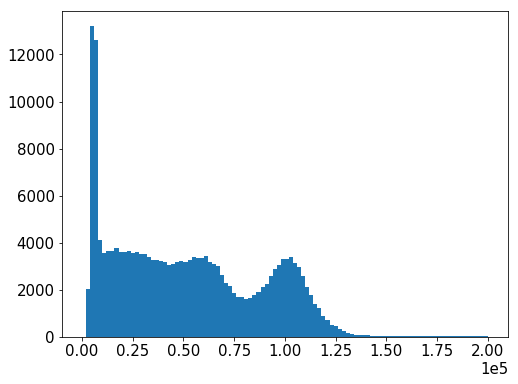

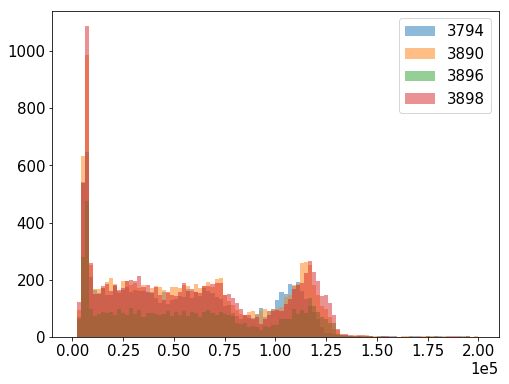

In [9]:
data_read_combined = pd.concat(data_read)
hist(data_read_combined.S2e, 100, [0, 2e5]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.figure()
for i in data_read[-4::]: 
    plt.hist(i.S2e, 100, [0, 2e5], alpha=0.5)
plt.legend(run_number[-4::])

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

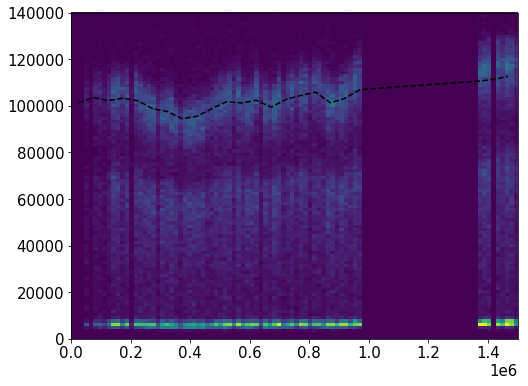

In [10]:
data = data_read_combined[(data_read_combined.Z<210)&(data_read_combined.R<180)]

Et = data.S2e 

time = data.time
time = time-np.min(time)
hist2d(time,Et,[100,100], range=[[0,1.5e6],[0,1.4e5]]);
x, y, _ = fitf.profileX(time,Et, 30, yrange=[0.8e5,2e5])
plt.plot(x,y,profOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

3.0277356263699207

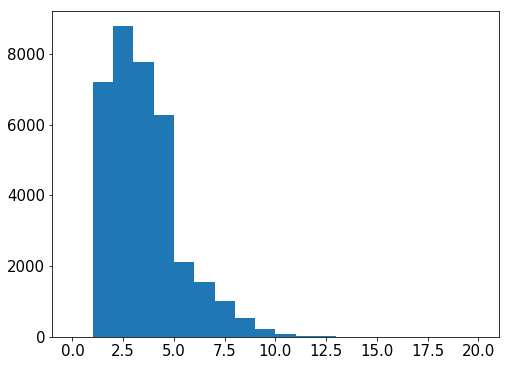

In [11]:
hist(data_read_combined[(data_read_combined.nS2>0)&(data_read_combined.S2e<12e3)].Nsipm, 20, [0,20]);
np.mean(data_read_combined[(data_read_combined.nS2>0)&(data_read_combined.S2e<12e3)].Nsipm)


### XR Filter

In [12]:
from copy import deepcopy
from functools import reduce

def Filter(data, verbosity=False):
    filtered_XR = deepcopy(data)
    filtered_noXR = deepcopy(data)
    
    min_S1w = 250.
    max_S1w = 400.
    min_S1h = 10.
    max_S1h = 100.
    
    min_S2e = 2500.
    max_S2e = 10000.
    
    if verbosity: print('Inicial: ',len(filtered_XR), len(filtered_noXR))

    filtered_XR = filtered_XR[filtered_XR.nS2>1]
    if verbosity: print('nS2 > 1: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.S2e>min_S2e]
    filtered_XR = filtered_XR[filtered_XR.S2e<max_S2e]
    
    
    if verbosity: print('S2 XR Energy: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.Nsipm>0]
    
    if verbosity: print('Nsimp > 0: ', len(filtered_XR))
    

    
    
    #filtered_noXR = filtered_noXR[filtered_noXR.S2e<min_S2e]
    filtered_noXR = filtered_noXR[filtered_noXR.S2e>max_S2e]
    
    if verbosity: print('no XR: ', len(filtered_noXR))
    
    return filtered_XR, filtered_noXR


In [13]:
filt_XR, filt_noXR = [], []
j = 0
for i in data_read:
    print(run_number[j])
    XR, noXR = Filter(i,True)
    filt_XR.append(XR)
    filt_noXR.append(noXR)
    print("\n")
#full = data_read[:]

3708
Inicial:  18 18
nS2 > 1:  14
S2 XR Energy:  2
Nsimp > 0:  2
no XR:  16


3708
Inicial:  1076 1076
nS2 > 1:  564
S2 XR Energy:  151
Nsimp > 0:  151
no XR:  901


3708
Inicial:  3464 3464
nS2 > 1:  1810
S2 XR Energy:  480
Nsimp > 0:  480
no XR:  2911


3708
Inicial:  13899 13899
nS2 > 1:  7703
S2 XR Energy:  2161
Nsimp > 0:  2161
no XR:  11576


3708
Inicial:  16682 16682
nS2 > 1:  8791
S2 XR Energy:  2437
Nsimp > 0:  2437
no XR:  13980


3708
Inicial:  14870 14870
nS2 > 1:  7868
S2 XR Energy:  2185
Nsimp > 0:  2185
no XR:  12454


3708
Inicial:  17051 17051
nS2 > 1:  8931
S2 XR Energy:  2467
Nsimp > 0:  2467
no XR:  14324


3708
Inicial:  16570 16570
nS2 > 1:  8883
S2 XR Energy:  2523
Nsimp > 0:  2523
no XR:  13821


3708
Inicial:  6492 6492
nS2 > 1:  3543
S2 XR Energy:  967
Nsimp > 0:  967
no XR:  5441


3708
Inicial:  9593 9593
nS2 > 1:  5262
S2 XR Energy:  1489
Nsimp > 0:  1489
no XR:  7990


3708
Inicial:  6688 6688
nS2 > 1:  3739
S2 XR Energy:  1085
Nsimp > 0:  1085
no XR:  55

In [14]:
min_len   = 1000
DataXR    = [Filter(data)[0] for data in data_read]
len_XR    = [len(data) for data in DataXR]
min_runs  = np.where(np.array(len_XR)>min_len)[0]
print(run_number)
print(len_XR)
print(min_runs)

['3708', '3723', '3732', '3740', '3752', '3755', '3757', '3761', '3763', '3768', '3770', '3773', '3779', '3781', '3783', '3787', '3789', '3791', '3794', '3890', '3896', '3898']
[2, 151, 480, 2161, 2437, 2185, 2467, 2523, 967, 1489, 1085, 1388, 596, 487, 1260, 1045, 1463, 1353, 1380, 1852, 877, 1885]
[ 3  4  5  6  7  9 10 11 14 15 16 17 18 19 21]


In [15]:
rcut = 180.
data_cut = {}
def get_zcorr(zfun, coef):
    def zcorr(z):
        return zfun(coef)/zfun(z)
    return zcorr



#### 0: 3740

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f67181c7048>, values=array([ 7804.67443179,  -643.96729317]), errors=array([ 176.33573842,   55.12857714]), chi2=1.0661045122054496)


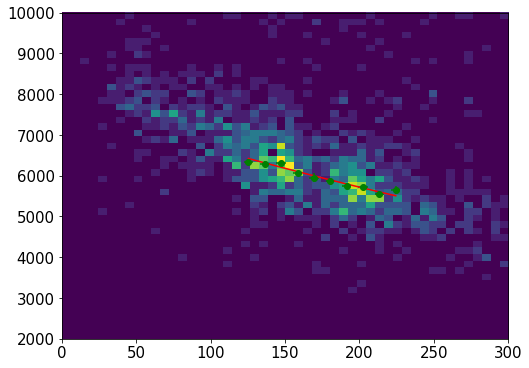

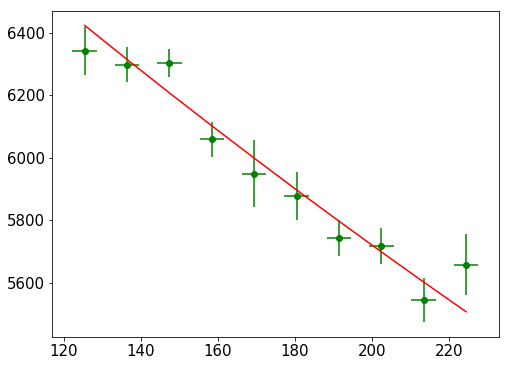

In [16]:
imin = min_runs[0]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [50,50], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 10, xrange=[120,230], yrange=[2000,7500])


sel                 = fitf.in_range(x, 165, 185)
#x, y, ey            = x[~sel], y[~sel], ey[~sel]
f                   = fitf.fit(fitf.expo, x, y, (1e5, -250), sigma=ey)
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 1: 3752

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f6717e52620>, values=array([ 8245.89054564,  -492.53550037]), errors=array([ 102.54611994,   17.96557925]), chi2=0.52515361707554908)


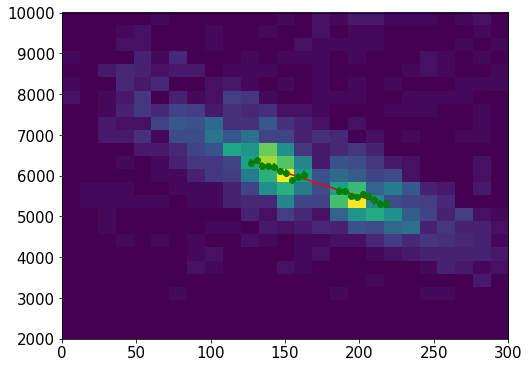

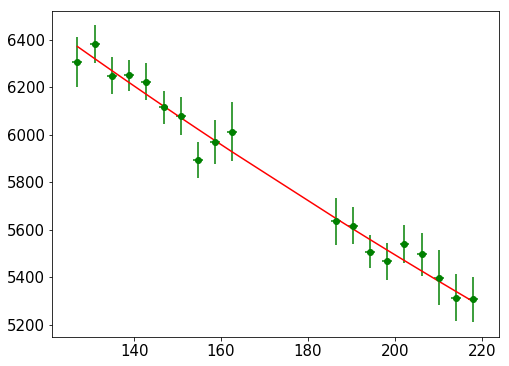

In [17]:
imin = min_runs[1]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 24, xrange=[125,220], yrange=[4000,7500])

sel                 = fitf.in_range(x, 165, 185)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
f                   = fitf.fit(fitf.expo, x, y, (1e5, -250), sigma=ey)

plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 2: 3755

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f6717d45268>, values=array([ 8521.37294514,  -396.91698351]), errors=array([ 230.1423761 ,   24.73203756]), chi2=1.1357055169041439)


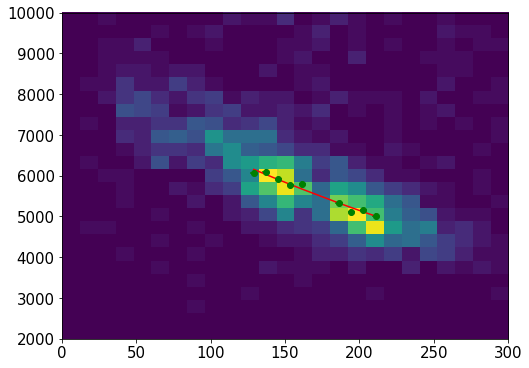

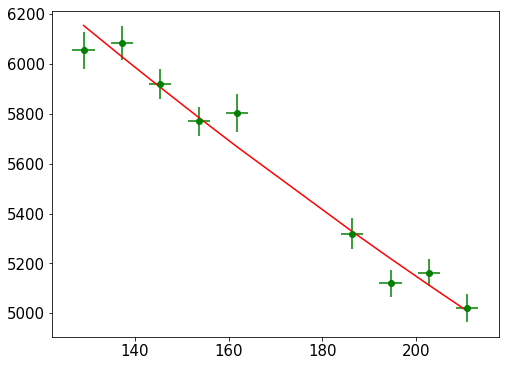

In [18]:
imin = min_runs[2]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 11, xrange=[125,215], yrange=[4000,7500])


sel                 = fitf.in_range(x, 165, 185)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
f                   = fitf.fit(fitf.expo, x, y, (1e5, -250), sigma=ey)

plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 3: 3757

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f67181b7488>, values=array([ 8555.81381718,  -386.86432709]), errors=array([ 149.36143049,   15.51966658]), chi2=0.9977391201608784)


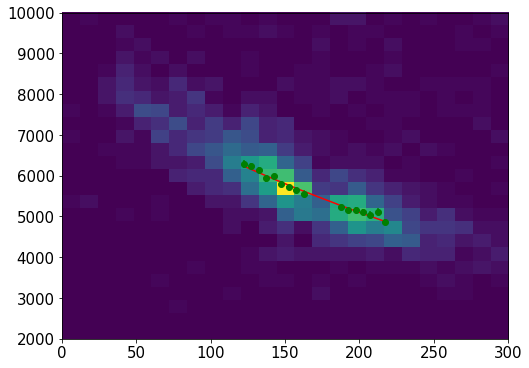

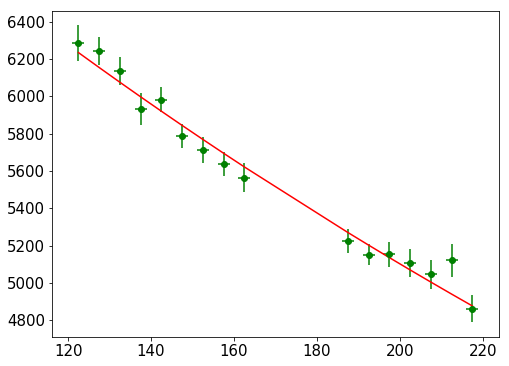

In [19]:
imin = min_runs[3]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 20, xrange=[120,220], yrange=[4000,7500])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 165, 185)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e5, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 4: 3761

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f6718aa91e0>, values=array([ 8124.73751714,  -516.73628834]), errors=array([ 139.65653087,   27.73901288]), chi2=0.97092726856085554)


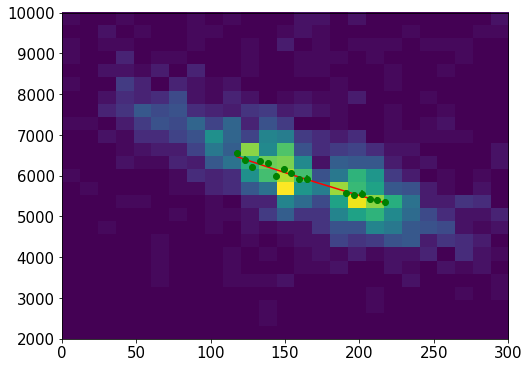

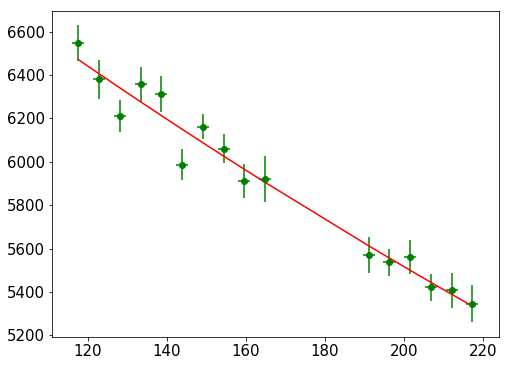

In [20]:
imin = min_runs[4]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 20, xrange=[115,220], yrange=[4000,7500])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 165, 190)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e5, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 5: 3768

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f671409f1e0>, values=array([ 8020.52382582,  -535.65923756]), errors=array([ 114.85468785,   25.39475237]), chi2=1.0325933287063778)


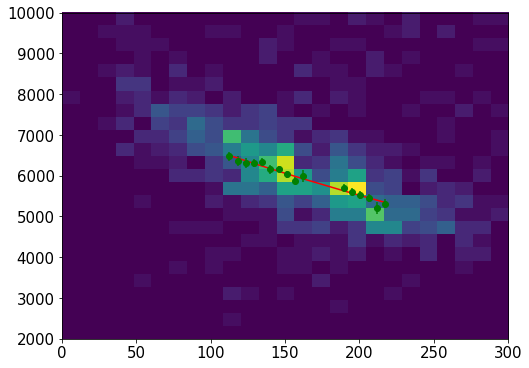

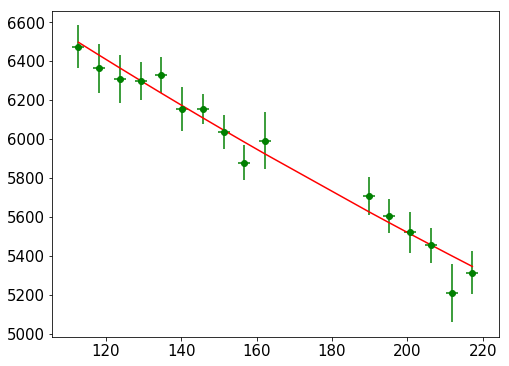

In [21]:
imin = min_runs[5]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 20, xrange=[110,220], yrange=[4000,7500])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 165, 185)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e5, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 6: 3770

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f6717e56510>, values=array([ 8774.03923266,  -405.88782627]), errors=array([ 158.36662674,   18.7262538 ]), chi2=0.7990831567054022)


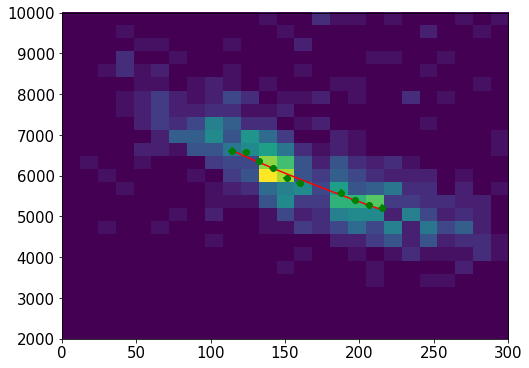

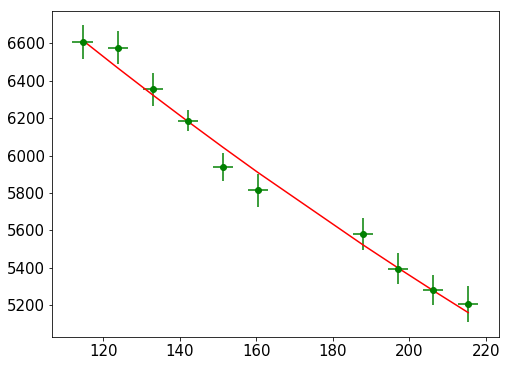

In [22]:
imin = min_runs[6]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 12, xrange=[110,220], yrange=[4000,7500])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 165, 185)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e5, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 7: 3773

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f67189476a8>, values=array([ 8377.99402693,  -477.89041244]), errors=array([ 148.01758553,   23.16591335]), chi2=1.0272465101844754)


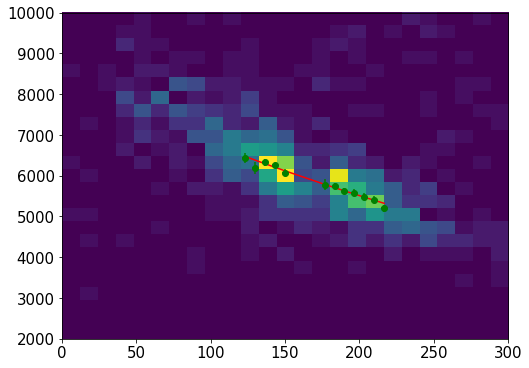

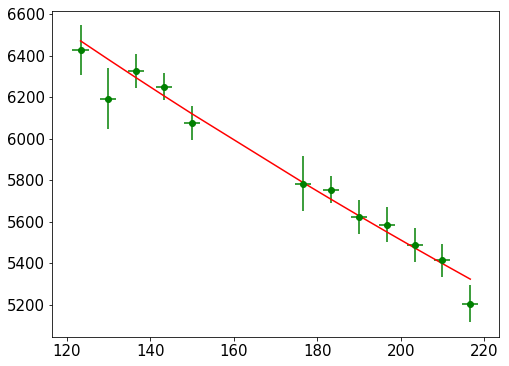

In [23]:
imin = min_runs[7]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 15, xrange=[120,220], yrange=[4000,7500])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 155, 175)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e5, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 8: 3783

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f671400a598>, values=array([ 8151.83976618,  -577.22166632]), errors=array([ 157.912733  ,   38.21630879]), chi2=0.89814145961904968)


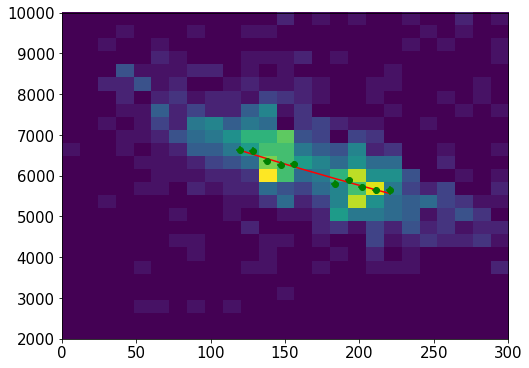

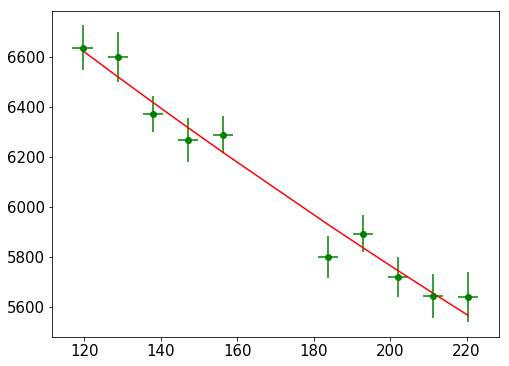

In [24]:
imin = min_runs[8]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 12, xrange=[115,225], yrange=[4000,7500])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 160, 180)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e5, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 9: 3787

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f6717dd8ae8>, values=array([ 8324.29607058,  -557.81100494]), errors=array([ 210.66240913,   45.88540867]), chi2=0.84647038398570995)


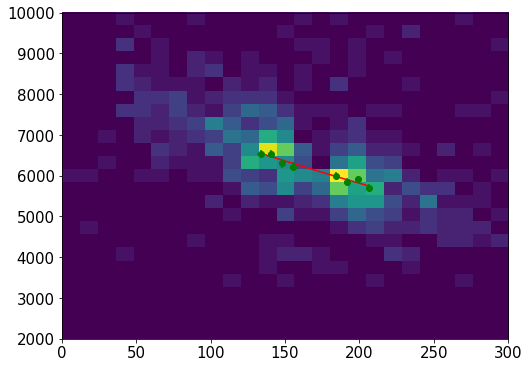

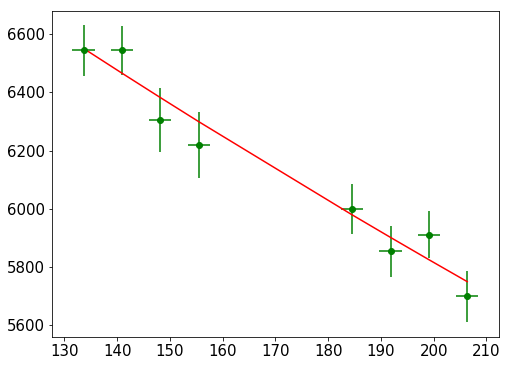

In [25]:
imin = min_runs[9]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 11, xrange=[130,210], yrange=[4000,7500])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 160, 180)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e5, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 10: 3789

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f6717d42ea0>, values=array([ 8294.51043065,  -492.99769264]), errors=array([ 211.2011651 ,   36.13345157]), chi2=1.0154002579879646)


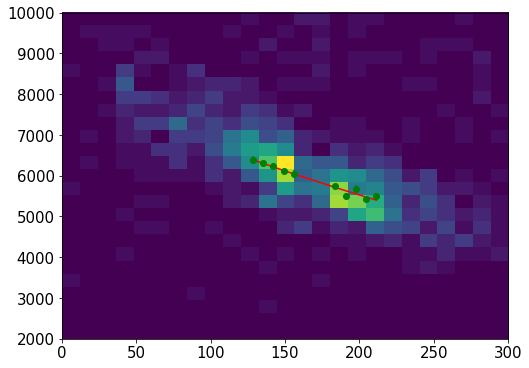

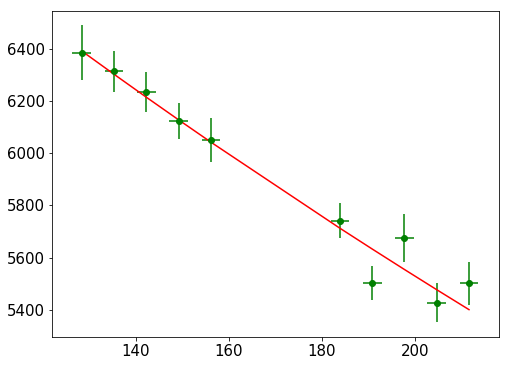

In [26]:
imin = min_runs[10]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 13, xrange=[125,215], yrange=[4000,7500])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 160, 180)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e4, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 11: 3791

In [27]:
run_number[min_runs[11]]

'3791'

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f671863c7b8>, values=array([ 8330.09843065,  -510.81643014]), errors=array([ 173.78983436,   34.6286423 ]), chi2=1.2105109989341334)


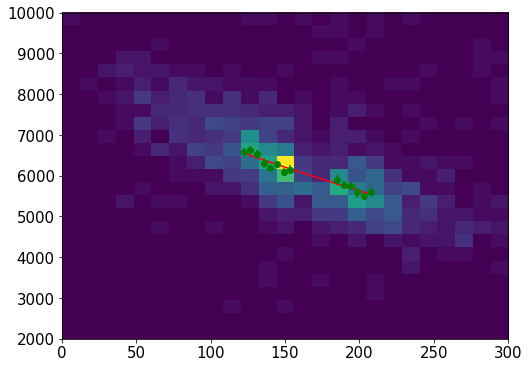

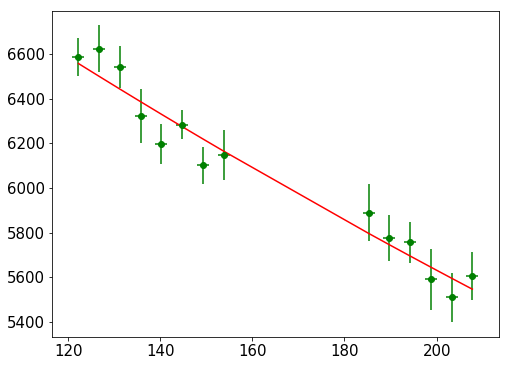

In [28]:
imin = min_runs[11]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 20, xrange=[120,210], yrange=[4000,7500])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 155, 185)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e4, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 12:  3794

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f671418b510>, values=array([ 8622.11603145,  -509.38203973]), errors=array([ 291.23324269,   54.69274705]), chi2=1.7463254952420471)


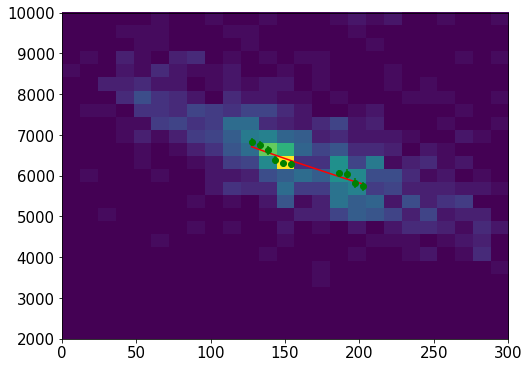

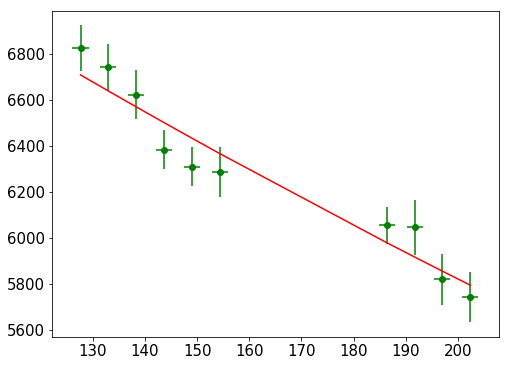

In [29]:
imin = min_runs[12]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 15, xrange=[125,205], yrange=[4000,8000])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 155, 185)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e4, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


#### 13: 3890

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f671414b8c8>, values=array([ 8292.4751779,  -699.2780481]), errors=array([ 209.00650187,   71.95290994]), chi2=1.0404851402019961)


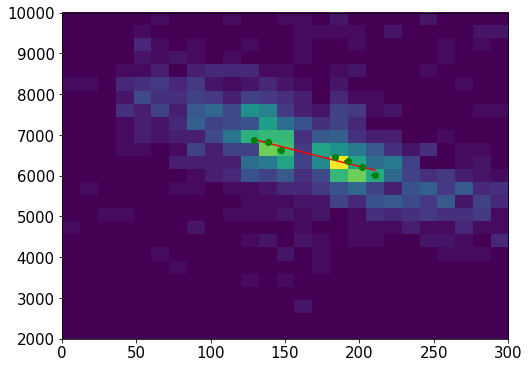

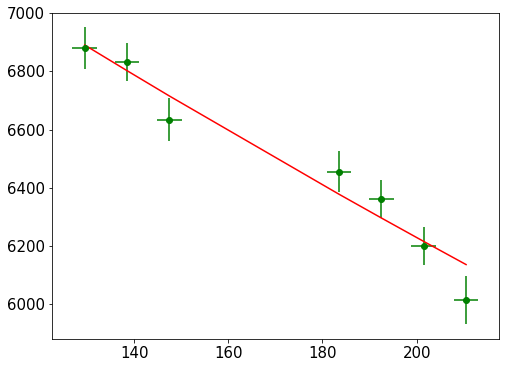

In [30]:
imin = min_runs[13]
idata = DataXR[imin]


idata_cut           = {}
idata_cut['run']    = run_number[imin]
data_               = idata[idata.R<rcut]
idata_cut['XR']     = deepcopy(idata)
idata_cut['Full']   = deepcopy(data_read[imin])

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 10, xrange=[125,215], yrange=[4000,8000])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 155, 180)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e4, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

idata_cut['zcorr']  = get_zcorr(f.fn, np.min(x))

idata_cut['zfit']   = f


data_cut[run_number[imin]] = idata_cut
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


In [31]:
x    = [data_cut[idata]['run']            for idata in sorted(data_cut)]
y    = [data_cut[idata]['zfit'].values[1] for idata in sorted(data_cut)]
ey   = [data_cut[idata]['zfit'].errors[1] for idata in sorted(data_cut)]
chi2 = [data_cut[idata]['zfit'].chi2      for idata in sorted(data_cut)]
n    = [len(data_cut[idata]['XR'])        for idata in sorted(data_cut)]

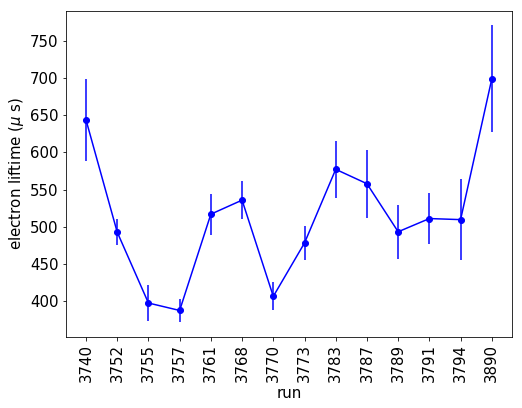

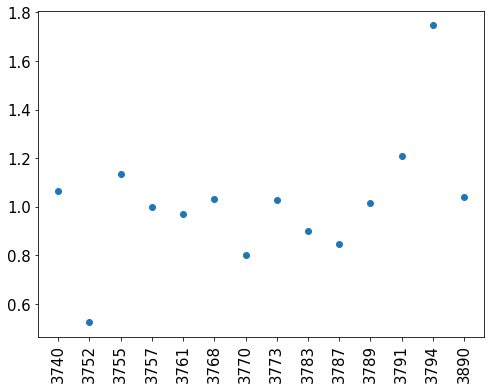

In [32]:
eyn = np.array(ey)
a = plt.errorbar(range(len(x)),abs(np.array(y)),eyn, marker='o', color='b')
plt.xticks(range(len(x)),x,rotation='vertical')
labels('run', r'electron liftime ($\mu$ s)')
plt.show()

plt.plot(range(len(x)), chi2, 'o')
plt.xticks(range(len(x)),x,rotation='vertical')
#plt.xticks(range(len(x)),x,rotation='vertical')

plt.show()

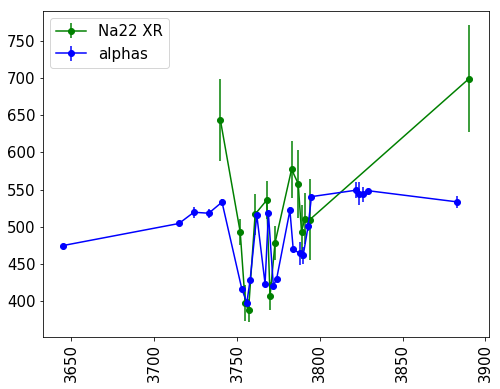

In [33]:
runs= [3645, 3715, 3724, 3733, 3741, 3753, 3756, 3758, 3762, 3767, 3769, 3772,
       3774, 3782, 3784, 3788, 3790, 3793, 3795, 3822, 3824, 3826, 3829,3883]

lifetimes = [474.41099311946277,  504.15251919578071, 519.30917837870686, 518.02811413069685, 532.97159910798757,
              415.51195316787062, 397.45427486981401, 428.51794570076862, 515.50856117526359, 422.80059055577334,
              518.02083320905024, 419.97646149139285, 429.75838777926833, 521.83297156881144, 469.21745429222761,
              463.826604058616, 461.06619446987372, 500.6616657051581, 540.39746211228908, 549.07810091024749,
              544.57593904287273, 543.26890350017925, 548.4509769880807,533.3]

elambdas = [0.45610521129754389, 0.39496148002734938, 7.1924391956263989, 6.3141707641315312, 4.5069070673219533,
             0.54717654845191099, 1.6326697526988669, 0.58043603501794649, 2.1244323267837881, 0.28654390913506583,
             3.822902769037376, 3.650949171398798, 1.5991794319982626, 4.2184333670711194, 0.2673803059344585,
            15.249539113903822, 11.22508358475883, 5.9907961163047405, 1.9609900515946075, 10.630602475189789,
             15.572425132253926, 10.651666662207665, 2.6543080579975458, 8.1]


eyn = np.array(ey)
xn  = np.array(x,dtype=np.float)
yn  = abs(np.array(y))
a = plt.errorbar(xn,yn,eyn,marker='o', color='g')
b = plt.errorbar(runs,lifetimes,elambdas,marker='o', color='b')

locs, labels = plt.xticks()
plt.legend(["Na22 XR", "alphas"], loc=2)
plt.setp(labels, rotation=90)
plt.show()



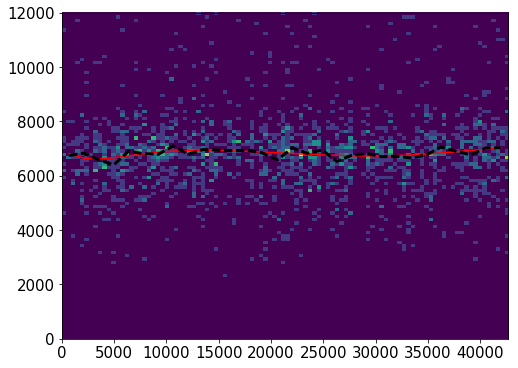

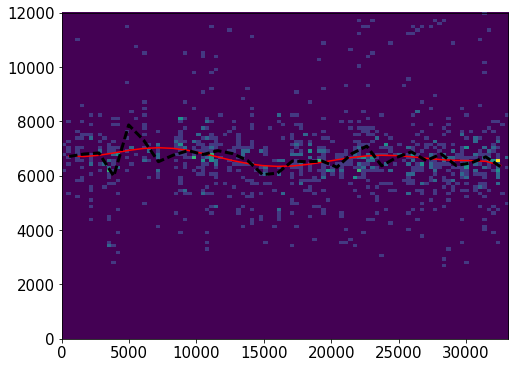

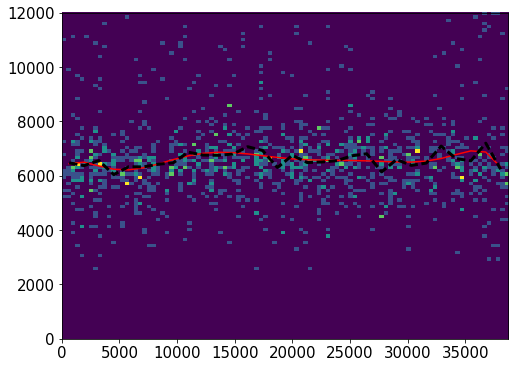

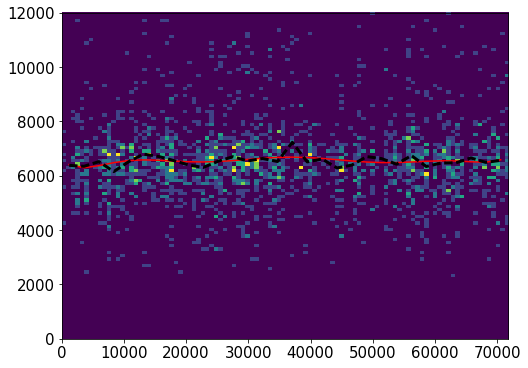

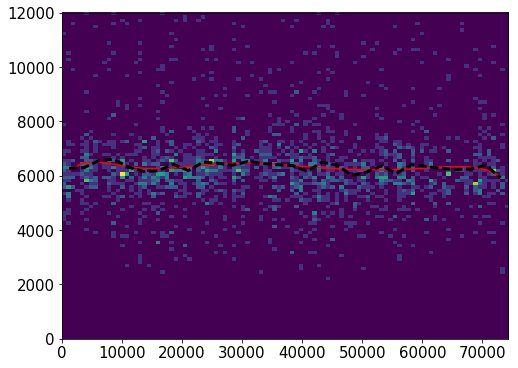

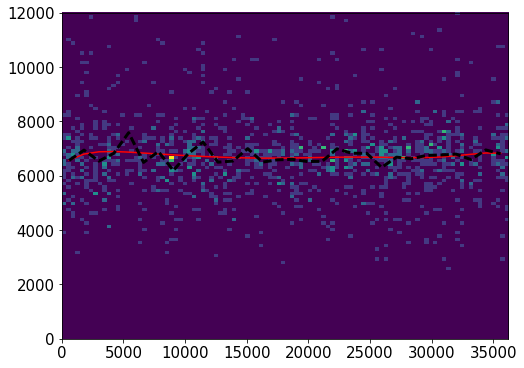

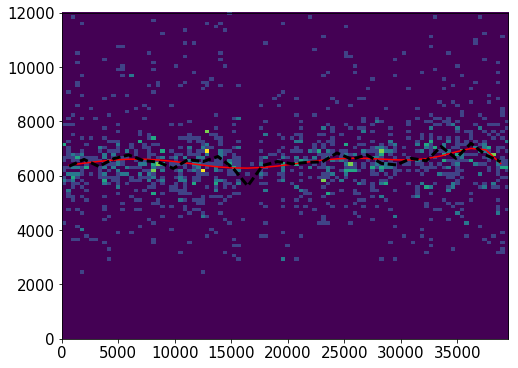

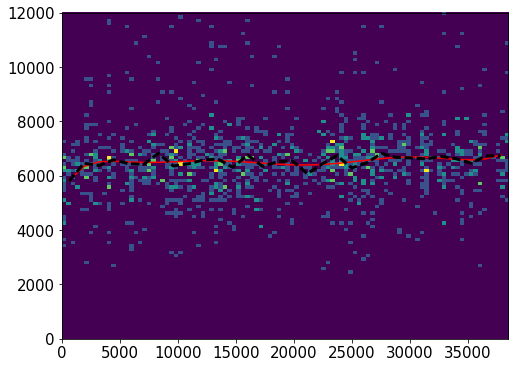

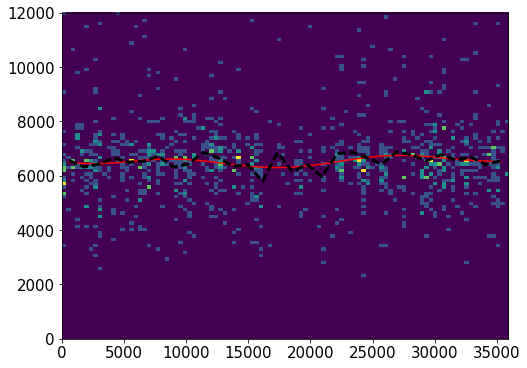

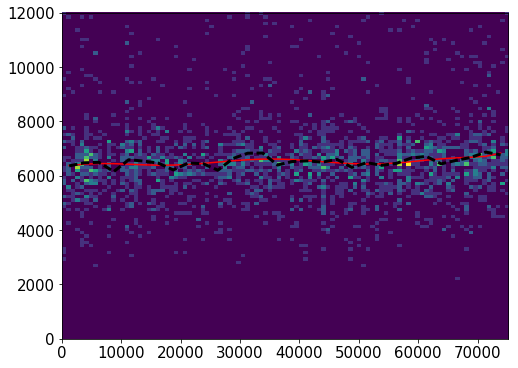

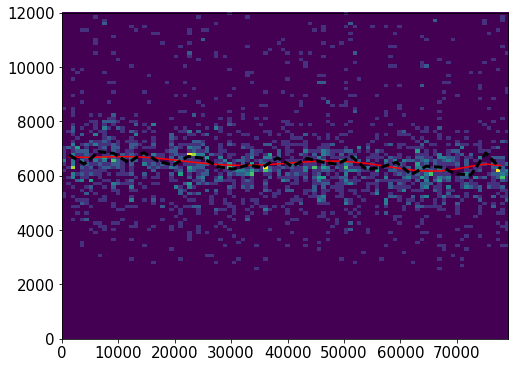

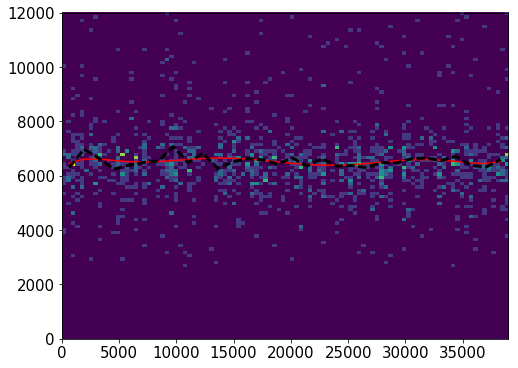

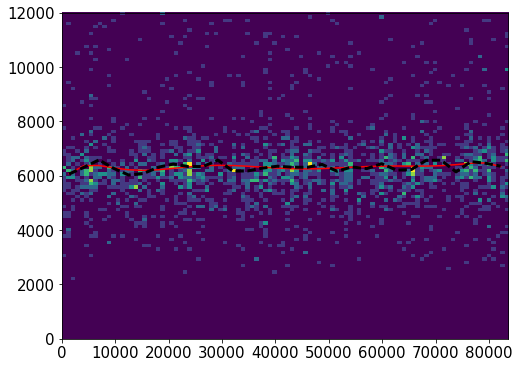

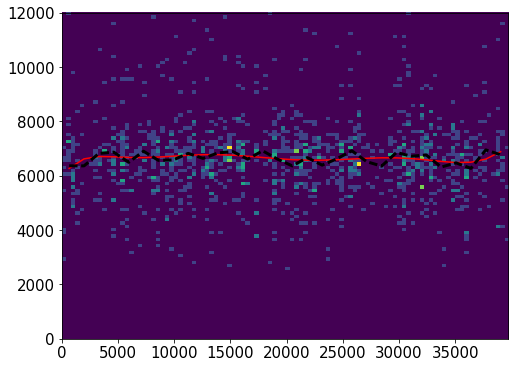

In [34]:
def get_tcorr(tfun, tmin):
    def tcorr(t):
        return tfun(tmin)/tfun(t)
    return tcorr

for run in data_cut:
    
    run          = data_cut[run]
    data_        = run['XR']
    E            = data_.S2e * run['zcorr'](data_.Z) #* xycorr(data_.X.values, data_.Y.values)
    time         = data_.time.values
    time        -= np.min(time)
    
    hist2d(time, E,[100,100],[[min(time),max(time)],[0,12e3]]);
    
    x, y, _      = fitf.profileX(time,E, 30, xrange = (min(time),max(time)), yrange=[0.8e0,12e3])
    f            = fitf.fit(fitf.polynom, x, y, (6000,-200,1,2,3,1,2,3,5))
    
    plt.plot(x, f.fn(x), fitOpt)
    #print(f.values,f.errors)

    plt.plot(x, y, profOpt, linewidth=3)
    #labels("time (s)", "Energy (pes)")
    
    run['tcorr'] = get_tcorr(f.fn, np.min(x))

In [35]:
data_cut_corr = deepcopy(data_cut)
for idata in data_cut_corr:
    
    data_1                           = data_cut_corr[idata]["XR"]
    time                             = data_1.time
    time                             = time-np.min(time)
    data_cut_corr[idata]["XR"].S2e   = data_1.S2e * data_cut_corr[idata]["zcorr"](data_1.Z) * data_cut_corr[idata]["tcorr"](time) 
    data_2                           = data_cut_corr[idata]["Full"]
    time                             = data_2.time
    time                             = time-np.min(time)
    data_cut_corr[idata]["Full"].S2e = data_2.S2e * data_cut_corr[idata]["zcorr"](data_2.Z) * data_cut_corr[idata]["tcorr"](time) 

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  2.07664902e+05   6.89503559e+03   5.74448727e+02   5.61070064e+03
   8.27569633e+03   1.00000000e+02   4.87882037e+00]
res 0.19620301205 0.0216758111381
[  1.14085634e+05   6.69404509e+03   5.26861190e+02   1.05257870e+04
   8.00000000e+03   3.67830368e+02   2.28164138e+00]
res 0.185352516628 0.0204770869847
[  1.53627879e+05   6.34940587e+03   5.88740286e+02   7.04366487e+03
   8.00000000e+03   5.99999997e+02   2.46323840e+00]
res 0.218364268998 0.0241241080076
[  2.38802617e+05   6.36290169e+03   6.27804018e+02   9.30125602e+03
   8.00000000e+03   3.28931801e+02   5.19355877e+00]
res 0.232359155509 0.0256702133082
[  2.33317742e+05   6.03791808e+03   5.69978669e+02   9.89436407e+03
   8.00000000e+03   6.00000000e+02   4.41975412e+00]
res 0.222311688794 0.0245602049109
[  1.54823615e+05   6.60653864e+03   5.89944495e+02   6.90562217e+03
   8.02552793e+03   2.13409476e+02   3.21691156e+00]
res 0.210294582374 0.0232325977226
[  1.55319049e+05   6.35943323e+03   5.77419853e+02   6.802

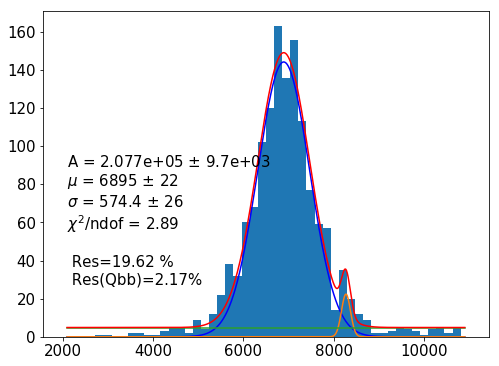

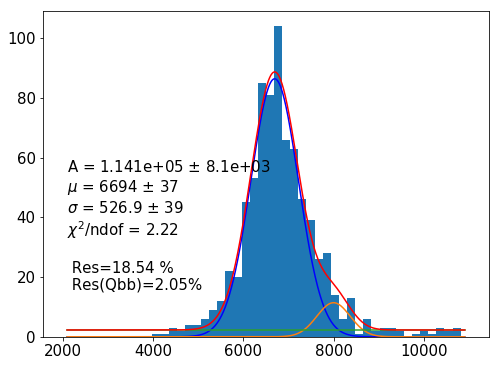

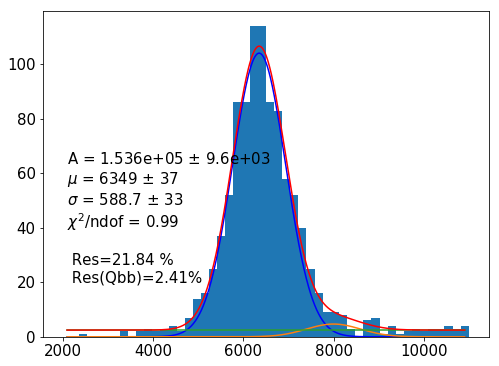

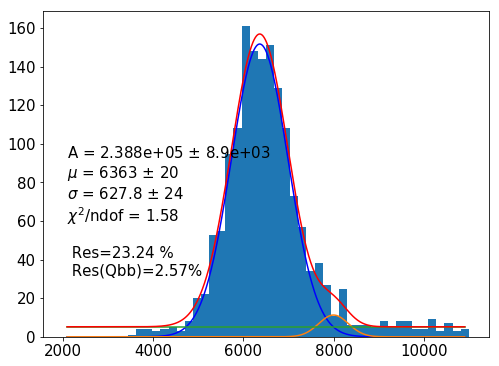

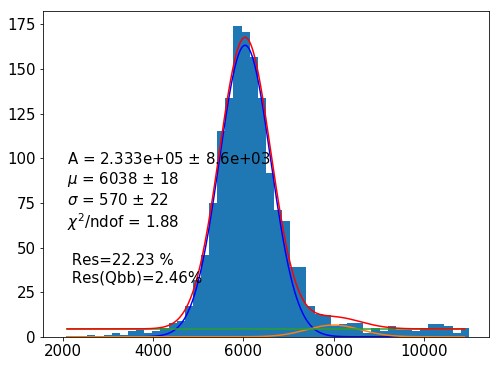

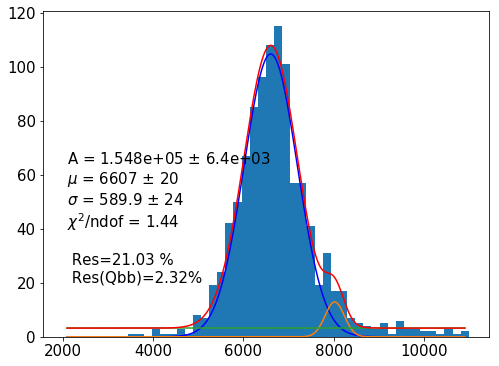

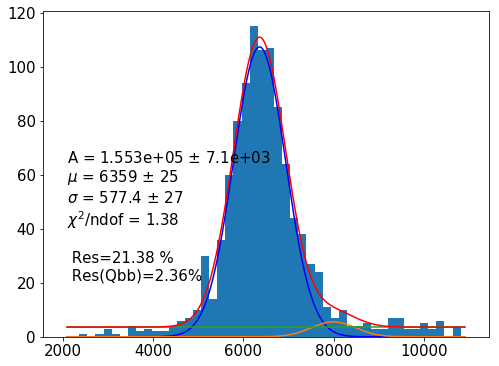

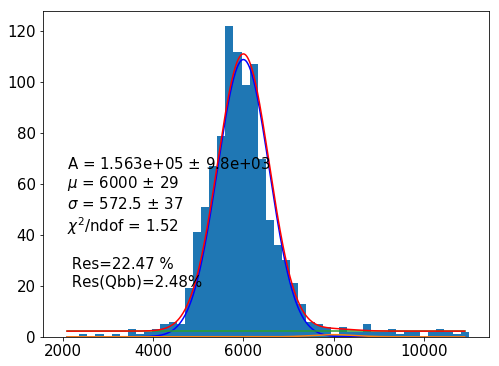

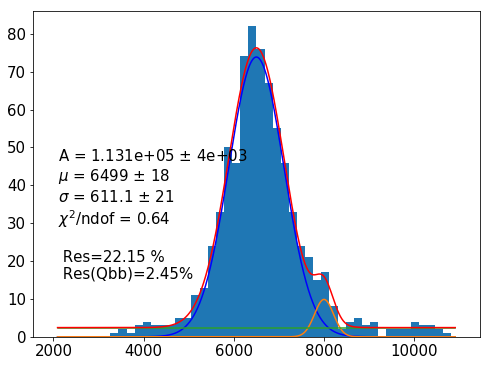

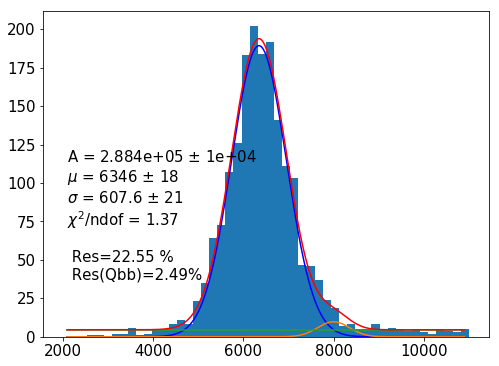

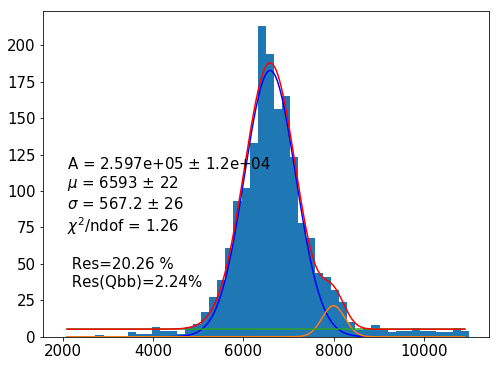

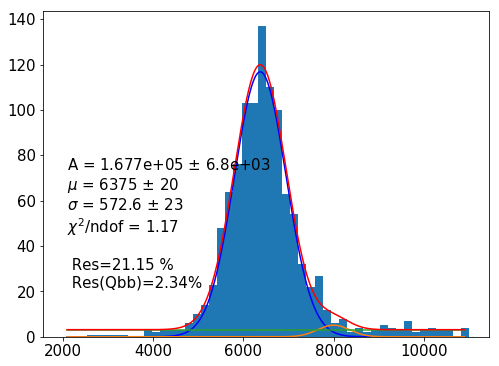

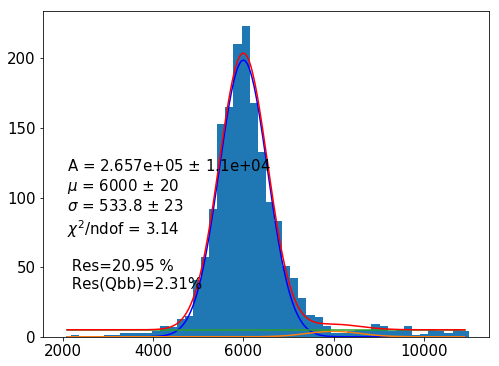

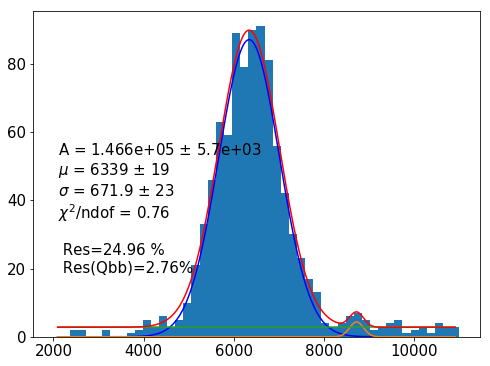

In [36]:
for idata in data_cut_corr:
    data_             = data_cut_corr[idata]["XR"]
    data_             = data_[(data_.R<180)]
    entries, xbins, _ = hist(data_.S2e,50,[2e3,11e3])
    xbins             = get_centers(xbins)
    selbins           = fitf.in_range(xbins,5000, 12000)


    f               = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 8050, 500, 10),
                                                                  bounds= ([ 1e4, 6000, 100, 0.1e4, 8000, 100, 0],
                                                                          [ 10e6, 8500, 700,10e5, 100000,600, 300] ))
    mean, sigma     = f.values[1], f.values[2]
    res             = 2.355*sigma/mean
    print(f.values)
    print('res',res,(30/2458)**0.5*res)

    text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                      for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                                f.values,
                                                f.errors)] + 
                     ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
    text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

    xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
    
    plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
    plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
    plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
    plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
    plt.plot(xrange, f.fn(xrange), fitOpt)
    #labels("Event energy (pes)", "Entries")
    
    data_cut_corr[idata]['mean_corr'] = f.values[1]

In [37]:
for idata in data_cut_corr:
    data_1      = data_cut_corr[idata]["XR"]
    data_1.S2e *=  8000./data_cut_corr[idata]["mean_corr"]
    data_2      = data_cut_corr[idata]["Full"]
    data_2.S2e *=  8000./data_cut_corr[idata]["mean_corr"]       

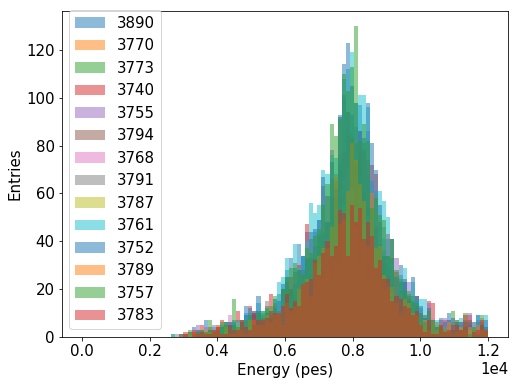

In [38]:
for idata in data_cut_corr: 
    plt.hist(data_cut_corr[idata]["XR"].S2e, 100, [0, 12e3], alpha=0.5)
plt.legend([data_cut_corr[run]["run"] for run in data_cut_corr])

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Energy (pes)')
plt.ylabel('Entries')
plt.show()

In [39]:
data_sum_corr    = pd.concat(data_cut_corr[idata]['Full'] for idata in data_cut_corr)
data_sum_corr_XR = pd.concat(data_cut_corr[idata]['XR'  ] for idata in data_cut_corr)

[  1.11043682e+06   8.09966851e+03   6.52703398e+02   5.32423182e+04
   9.65923154e+03   2.67006087e+02   2.75803252e+01]
res 0.189775235984 0.0209656932934


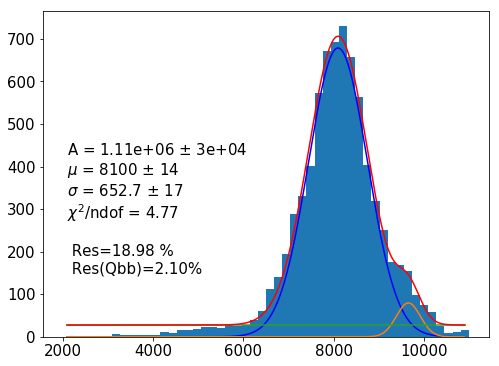

In [40]:
data_             = data_sum_corr_XR
data_             = data_[(data_.R<180)&(data_.Z<150)]
entries, xbins, _ = hist(data_.S2e,50,[2e3,11e3])
xbins             = get_centers(xbins)
selbins           = fitf.in_range(xbins,5000, 12000)


f                = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 8050, 500, 10),
                                                              bounds= ([ 1e4, 6000, 100, 0.1e4, 8000, 100, 0],
                                                                      [ 10e6, 8500, 700,10e5, 100000,600, 300] ))
mean, sigma      = f.values[1], f.values[2]
res              = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)

plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
#labels("Event energy (pes)", "Entries")

8223.22717675


"\nwith Corr_writer('xy_map____.h5') as writer:\n    #writer.write_z_corr (zcorr.xs, zcorr.fs, zcorr.us)\n    writer.write_xy_corr(*xycorr_for_josh.xs.T, xycorr_for_josh.fs, xycorr_for_josh.us, np.zeros_like(pf[2]))\n    #writer.write_t_corr (tcorr.xs, tcorr.fs, tcorr.us)\n"

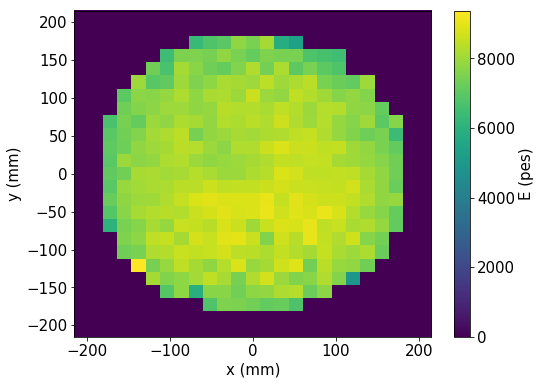

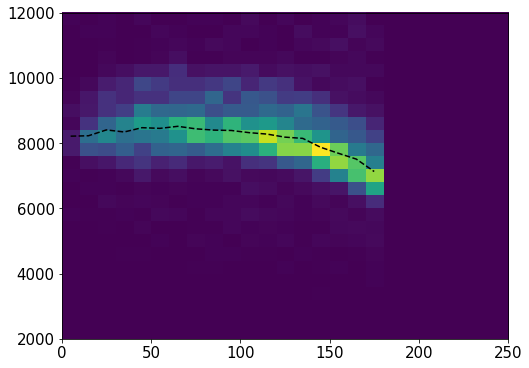

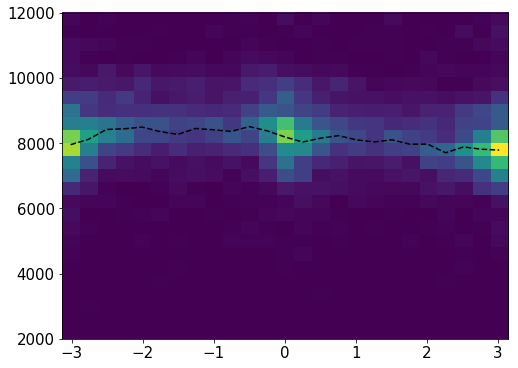

In [41]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 12e3
nbin = 25

#data = filt_XR[filt_XR.Z<150][:]
data = data_sum_corr_XR
data = data[(data.Z<150)&(data.R<180)][:]
Ez   = data.S2e 


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
#save("EvsXY")
"""_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")
"""

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
#labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
#labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

'''
np.savetxt('xycorr_xs_S1.dat',np.array(pf[0]))
np.savetxt('xycorr_ys_S1.dat',np.array(pf[1]))
np.savetxt('xycorr_es_S1.dat',np.array(pf[2]))

'''


def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])
xycorr_for_josh = Correction((pf[0],pf[1]), pf[2], pf[3])
'''
with Corr_writer('xy_map____.h5') as writer:
    #writer.write_z_corr (zcorr.xs, zcorr.fs, zcorr.us)
    writer.write_xy_corr(*xycorr_for_josh.xs.T, xycorr_for_josh.fs, xycorr_for_josh.us, np.zeros_like(pf[2]))
    #writer.write_t_corr (tcorr.xs, tcorr.fs, tcorr.us)
'''

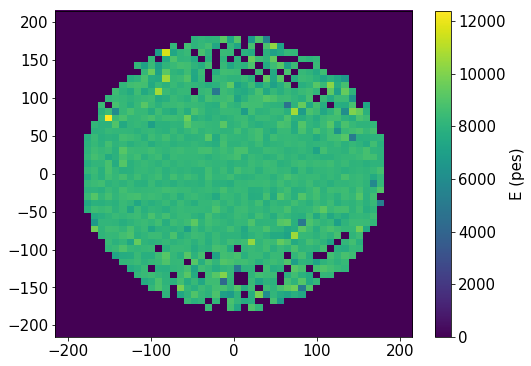

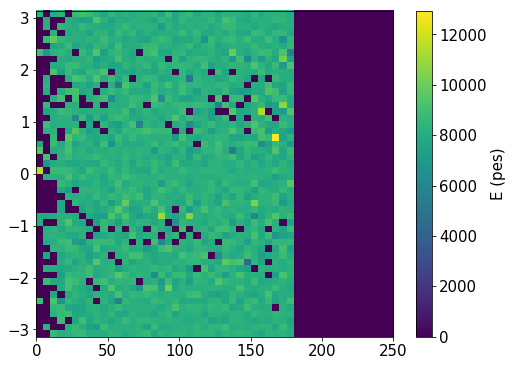

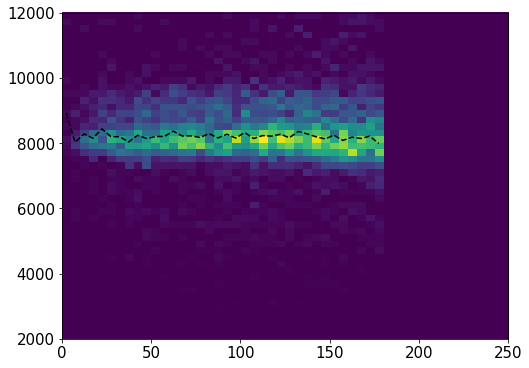

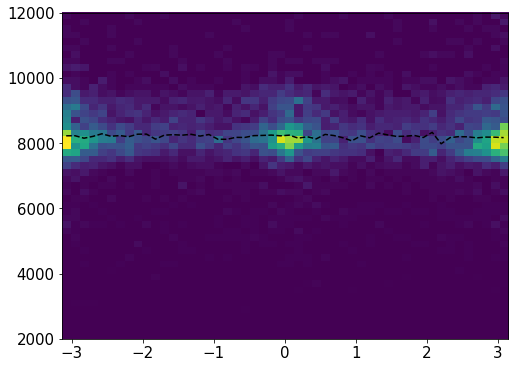

In [42]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 12e3
nbin = 50

#data = filt_XR[filt_XR.Z<150][:]
data = data_sum_corr_XR
data = data[(data.Z<150)&(data.R<180)][:]
Ez   = data.S2e * xycorr(data.X.values, data.Y.values)


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
#labels("x (mm)", "y (mm)")
#save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
#labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
#labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
#labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

[  4.56442995e+05   8.02789748e+03   3.13958804e+02   1.80785930e+05
   9.00009127e+03   4.39784486e+02   7.34735790e+00]
res 0.092100451614 0.0101749304155


/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


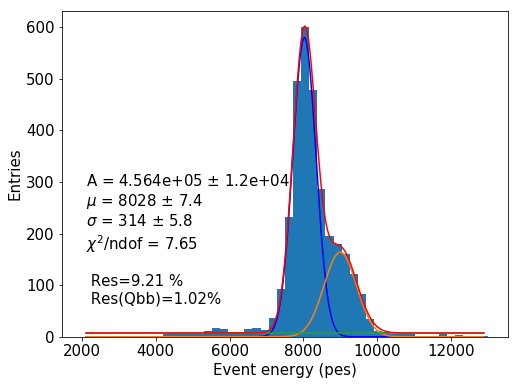

In [43]:
data_             = data_sum_corr_XR
data_             = data_[(data_.R<100)&(data_.Z<150)]
E                 = data_.S2e * xycorr(data_.X.values, data_.Y.values)
entries, xbins, _ = hist(E,50,[2e3,13e3])
xbins             = get_centers(xbins)
selbins           = fitf.in_range(xbins,5000, 13000)


f                = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 9050, 500, 10),
                                                              bounds= ([ 1e4, 6000, 100, 0.1e4, 8000, 100, 0],
                                                                      [ 10e6, 8500, 500,10e5, 100000,600, 300] ))
mean, sigma      = f.values[1], f.values[2]
res              = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)

plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.xlabel("Event energy (pes)")
plt.ylabel("Entries")

[  4.23164651e+05   8.03436249e+03   3.15756951e+02   1.53223723e+05
   9.03112252e+03   4.12068161e+02   7.91594657e+00]
res 0.0925534068318 0.0102249712974


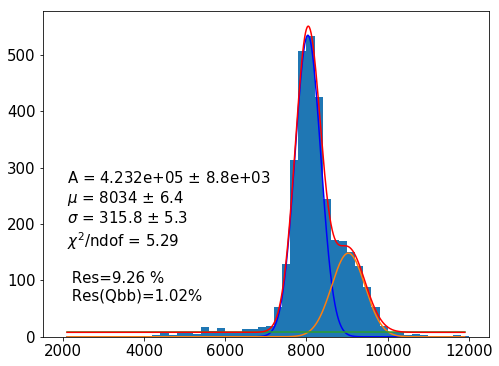

In [44]:
data_             = data_sum_corr_XR
data_             = data_[(data_.R<100)&(data_.Z<150)]
E                 = data_.S2e * xycorr(data_.X.values, data_.Y.values)
entries, xbins, _ = hist(E,50,[2e3,12e3])
xbins             = get_centers(xbins)
selbins           = fitf.in_range(xbins,5000, 12000)


f                = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 8050, 500, 10),
                                                              bounds= ([ 1e4, 6000, 100, 0.1e4, 8000, 100, 0],
                                                                      [ 10e6, 8500, 700,10e5, 100000,1000, 300] ))
mean, sigma      = f.values[1], f.values[2]
res              = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

xrange = np.linspace(np.min(xbins), np.max(xbins),1000)

plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]))
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
#labels("Event energy (pes)", "Entries")

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  1.56824980e+05   8.03321701e+03   3.20593142e+02   4.53856152e+04
   9.02907796e+03   3.62608306e+02   3.25562915e+00]
[  1.64433175e+05   8.03151061e+03   3.15653721e+02   4.96452449e+04
   9.01791867e+03   3.60319513e+02   3.70308294e+00]
[  1.75165736e+05   8.03558340e+03   3.15565390e+02   5.09223605e+04
   9.03559778e+03   3.51984659e+02   3.84455758e+00]
[  2.04295978e+05   8.08306022e+03   3.80473735e+02   3.18982144e+04
   2.91170278e+04   5.99970883e+02   9.07208799e+00]
[  1.94902055e+05   8.03823072e+03   3.19429354e+02   5.82352896e+04
   9.02618104e+03   3.63887569e+02   4.15180796e+00]
[  2.04628116e+05   8.03671261e+03   3.16080980e+02   6.27411577e+04
   9.02582484e+03   3.70942064e+02   4.26153235e+00]
[  2.18064401e+05   8.03939470e+03   3.17464156e+02   6.62604485e+04
   9.03266431e+03   3.72858826e+02   4.35359286e+00]
[  2.26574442e+05   8.04011071e+03   3.15774138e+02   7.34741421e+04
   9.03866426e+03   3.89880750e+02   4.36448796e+00]
[  2.35935500e+05   8.03

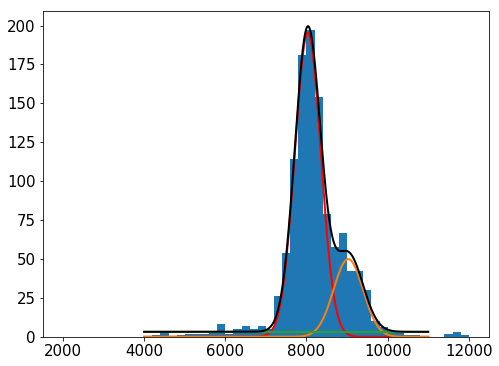

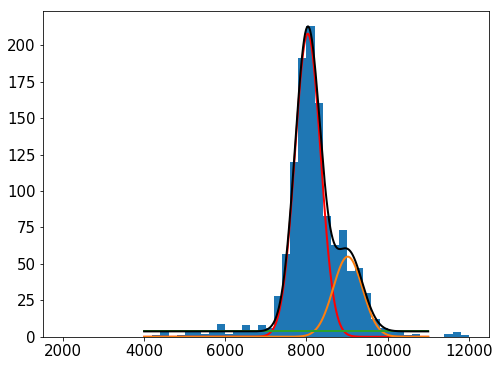

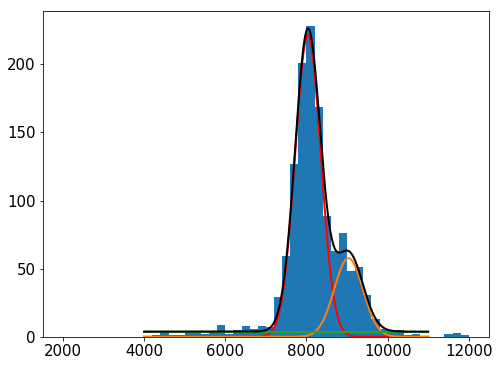

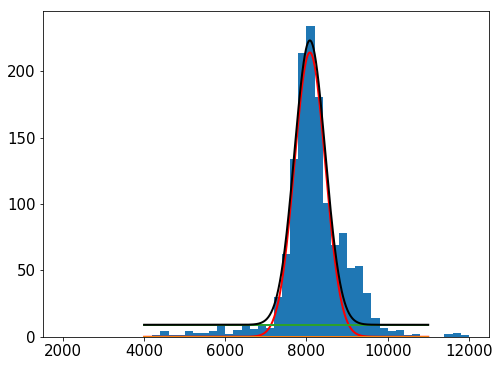

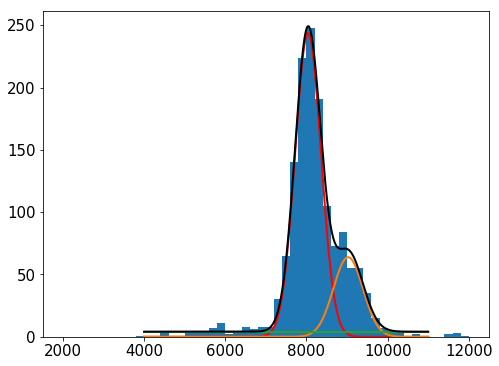

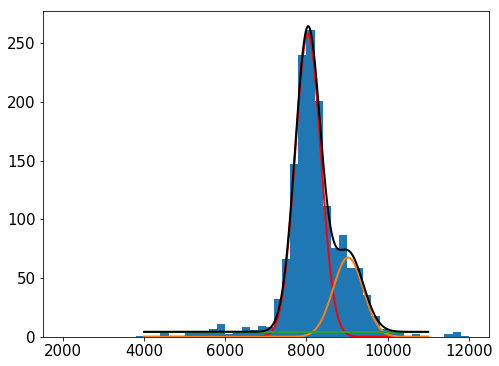

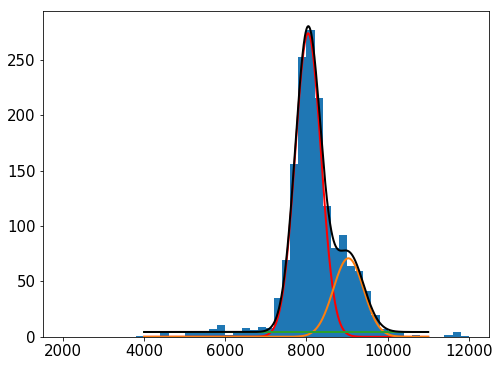

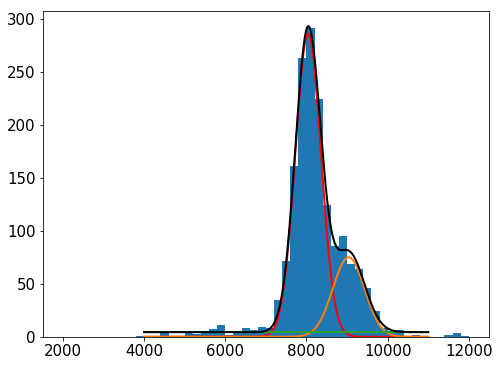

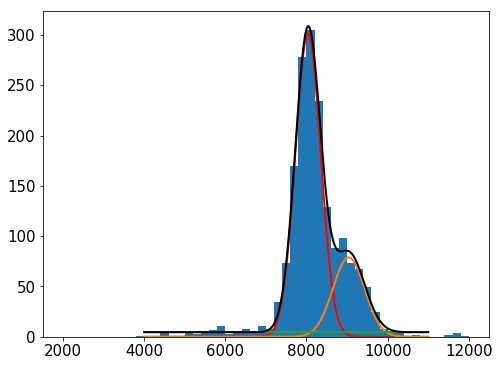

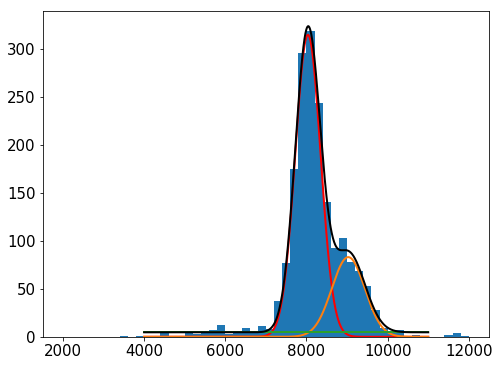

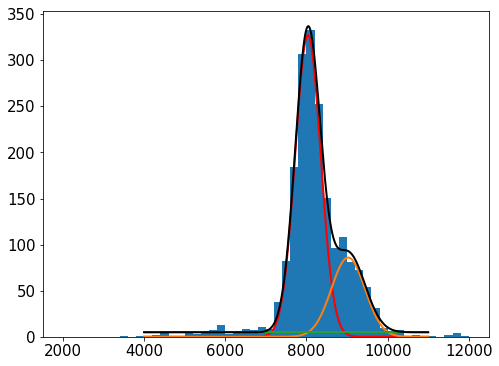

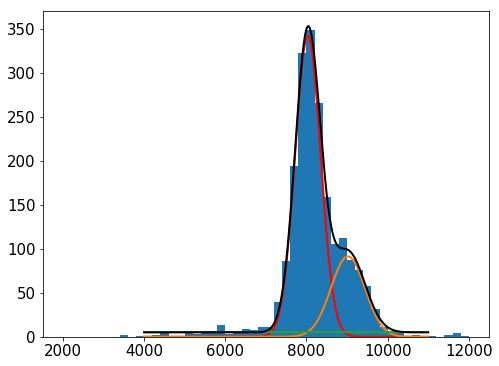

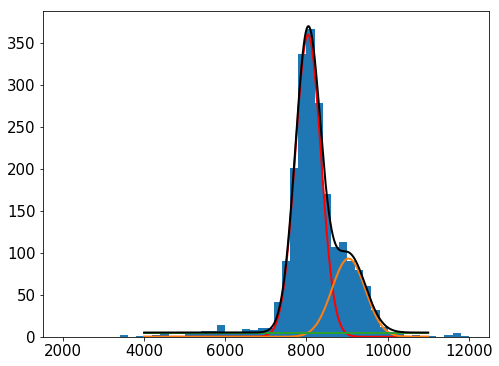

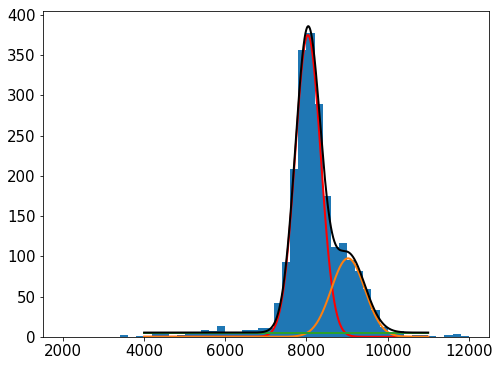

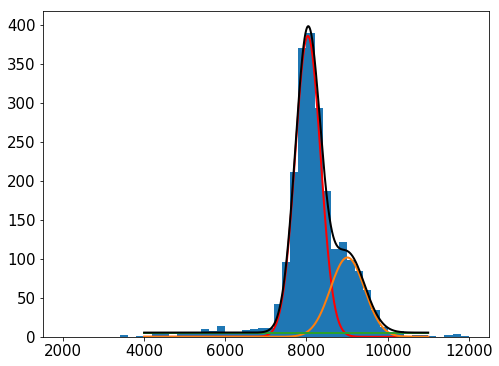

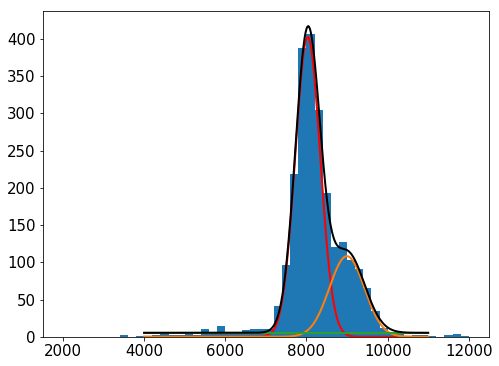

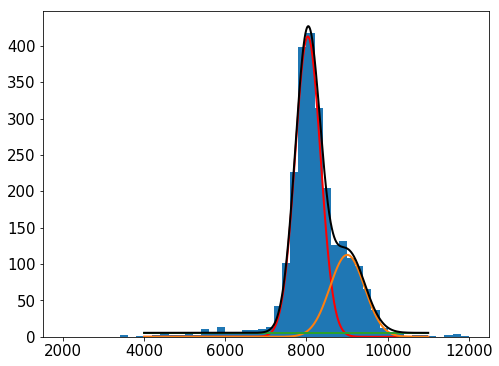

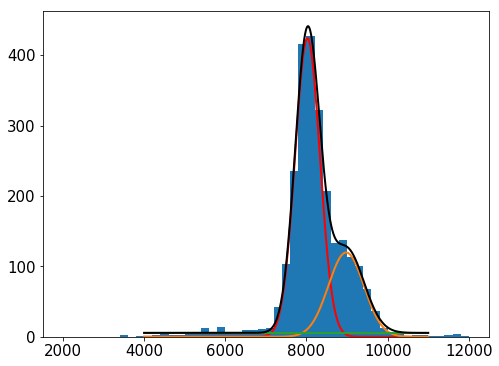

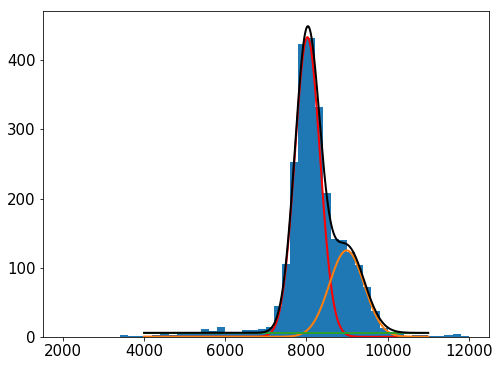

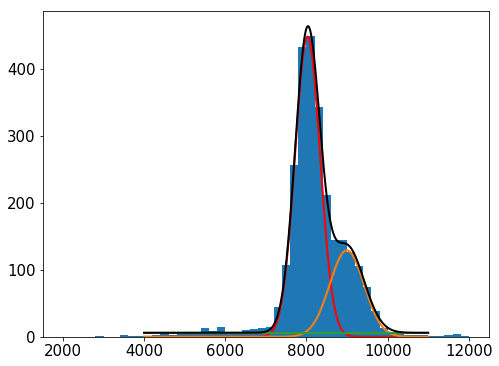

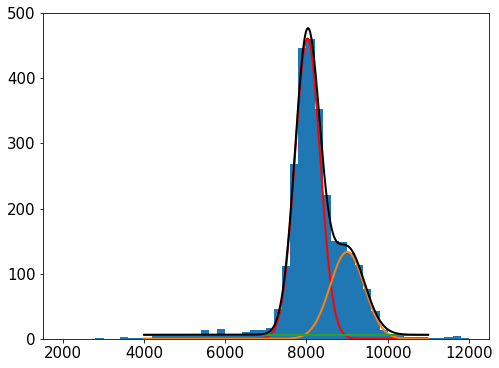

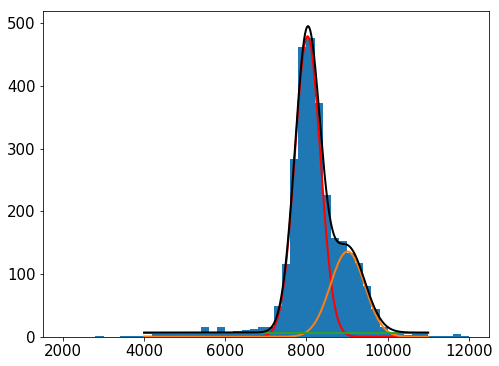

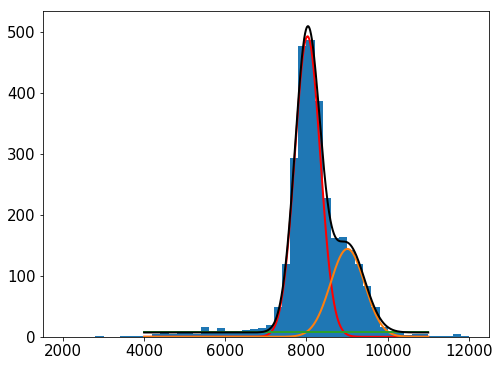

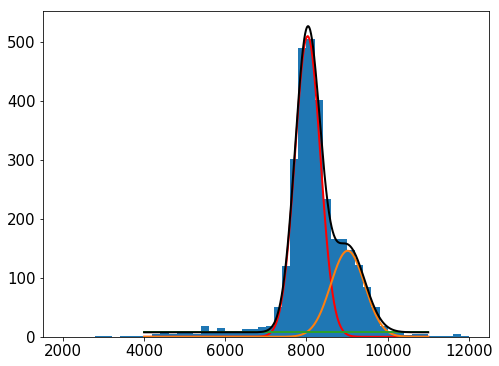

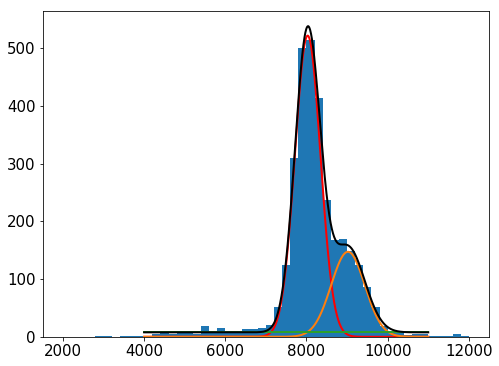

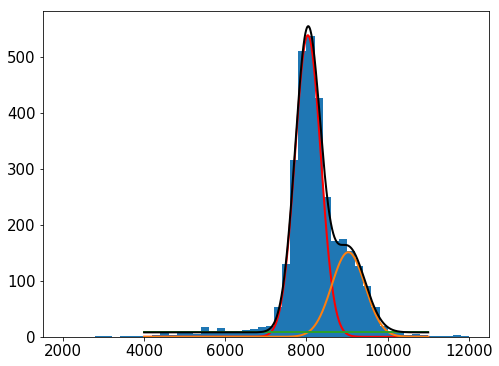

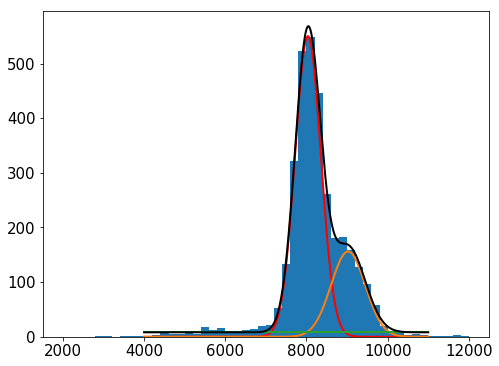

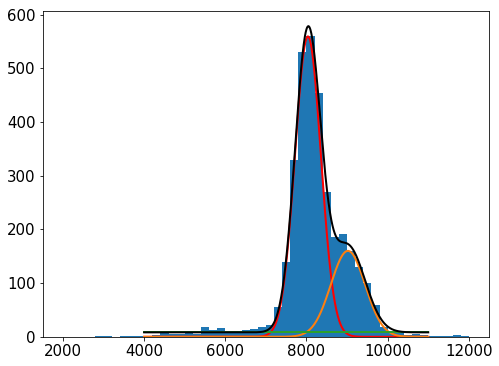

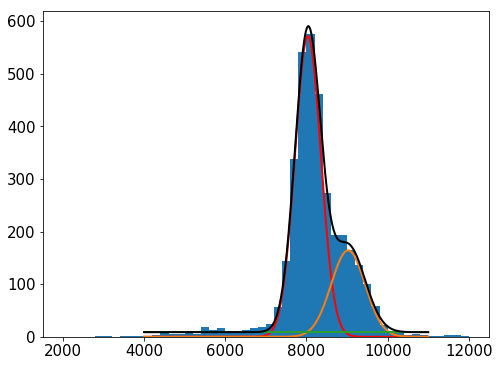

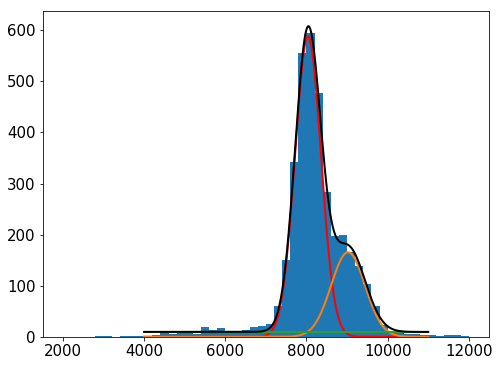

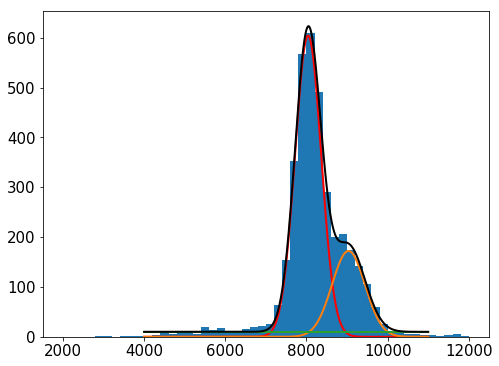

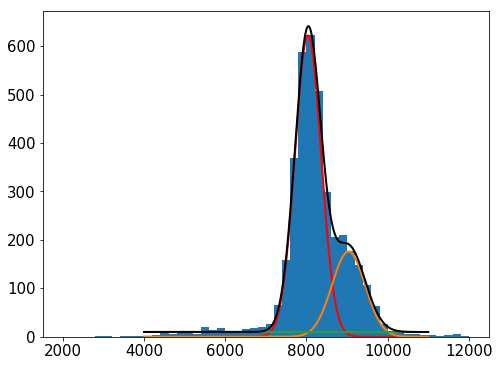

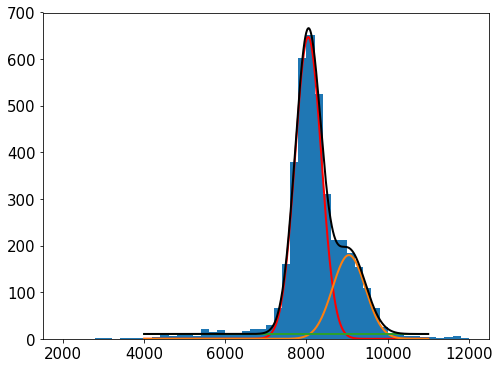

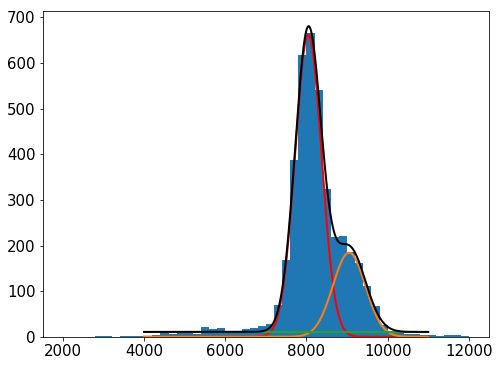

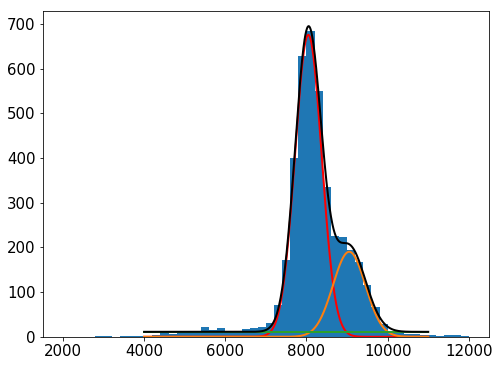

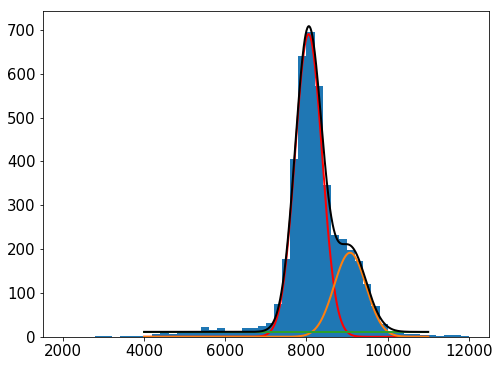

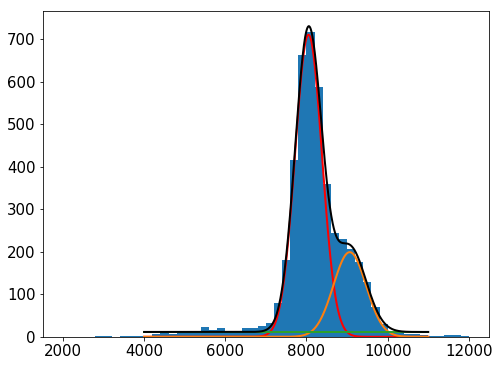

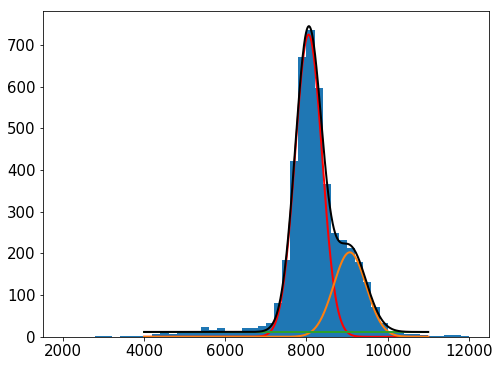

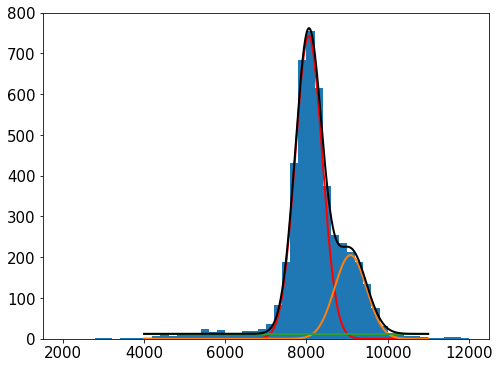

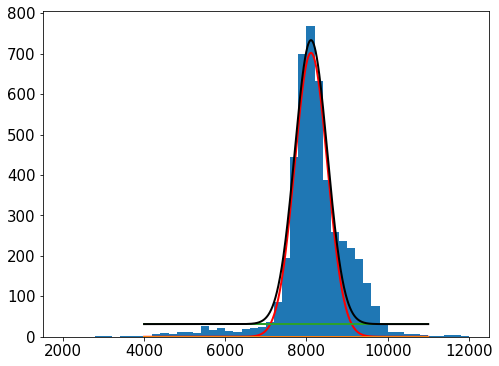

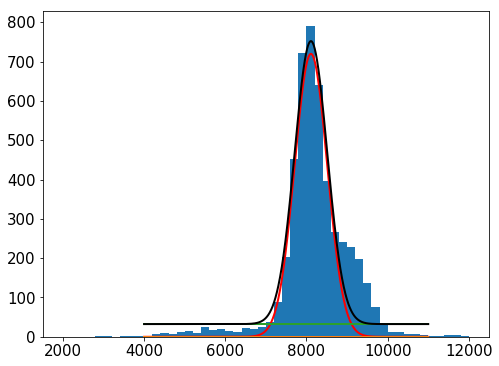

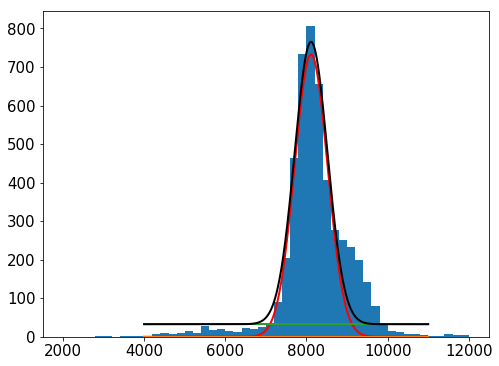

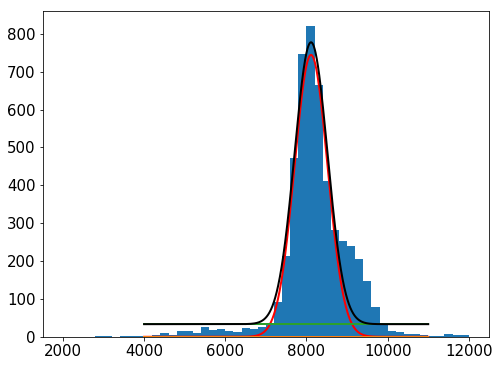

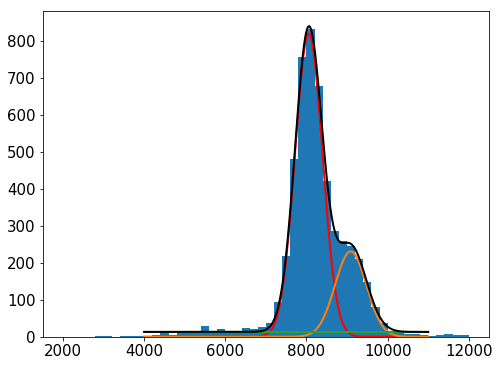

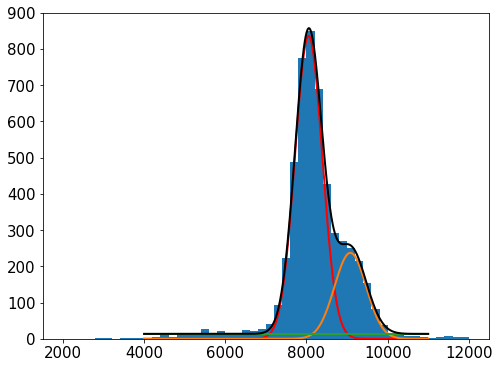

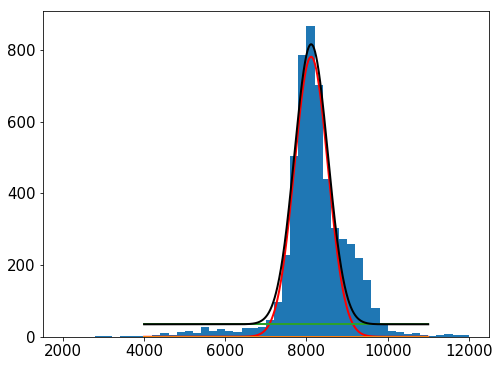

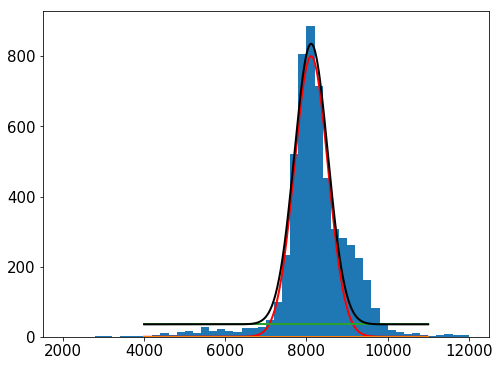

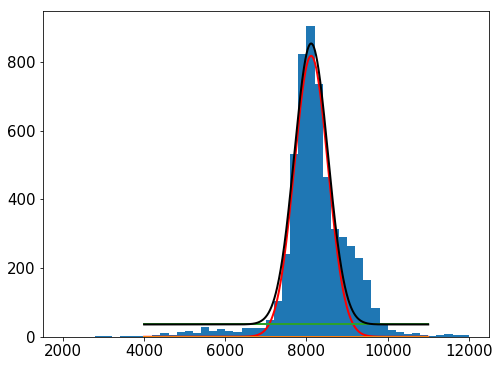

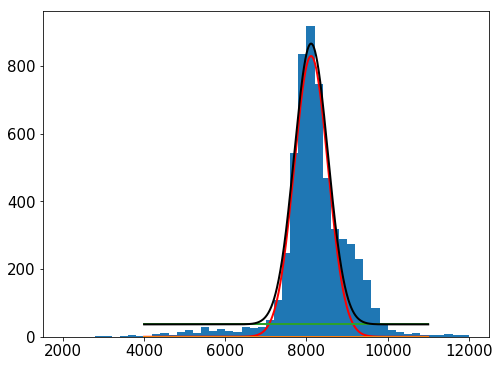

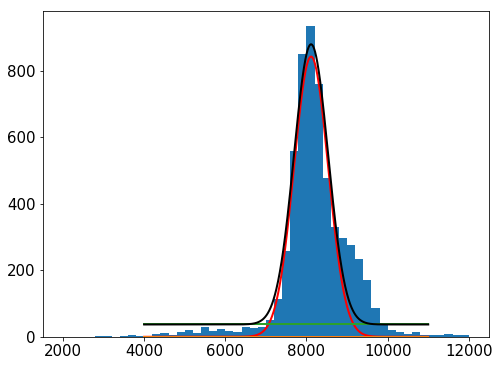

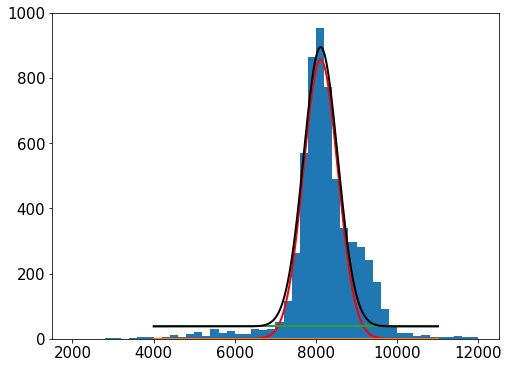

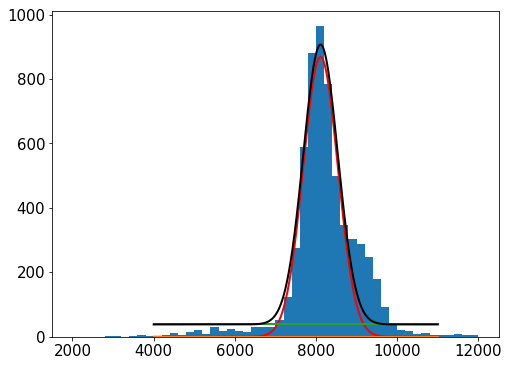

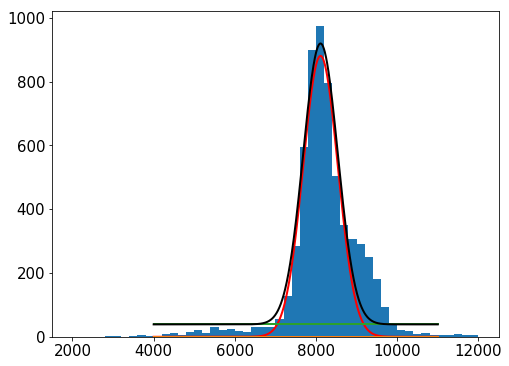

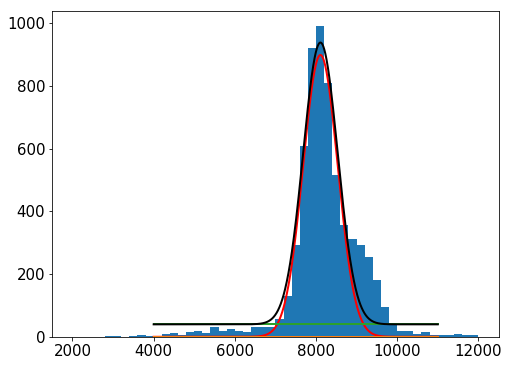

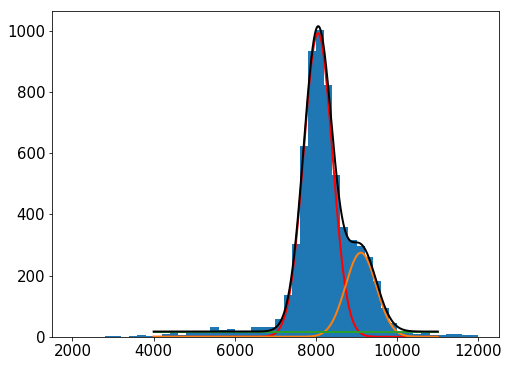

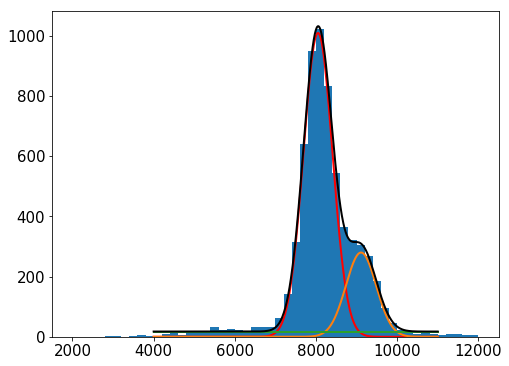

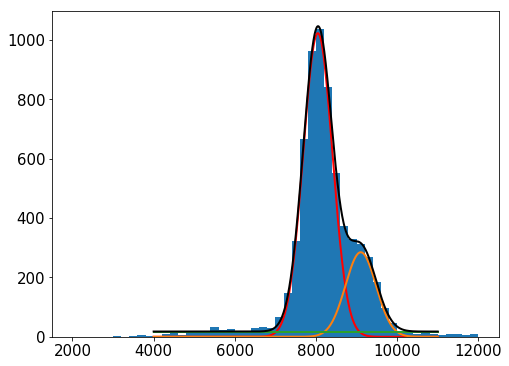

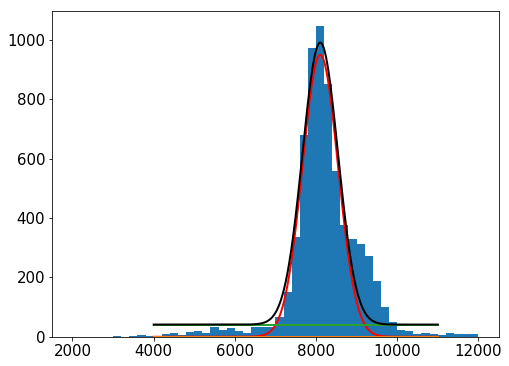

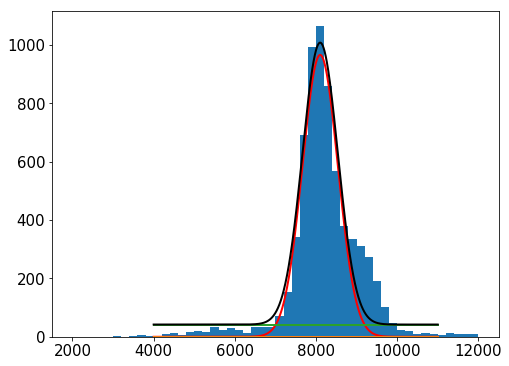

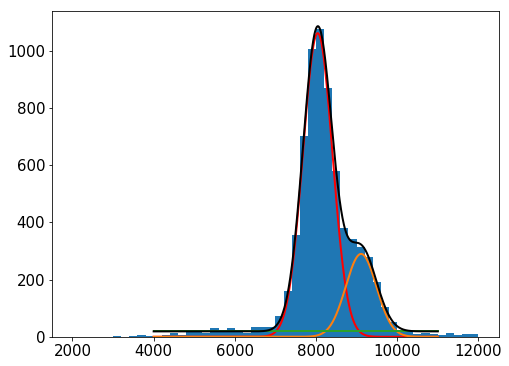

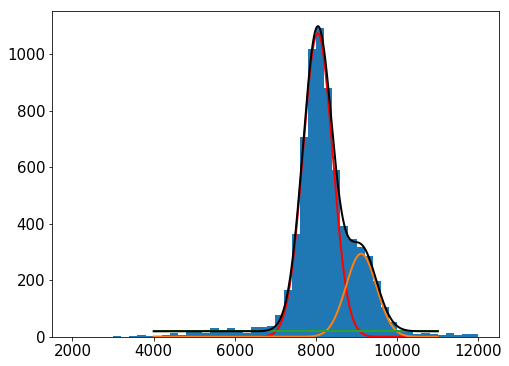

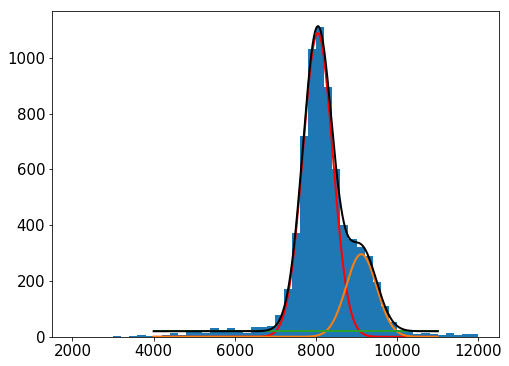

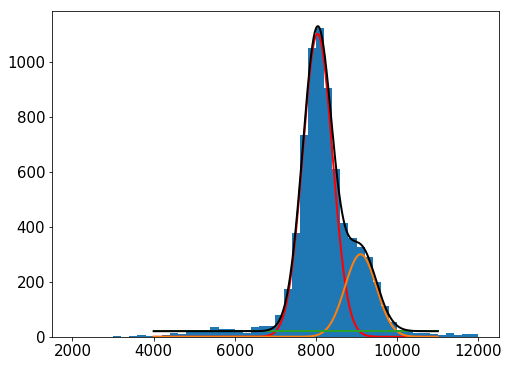

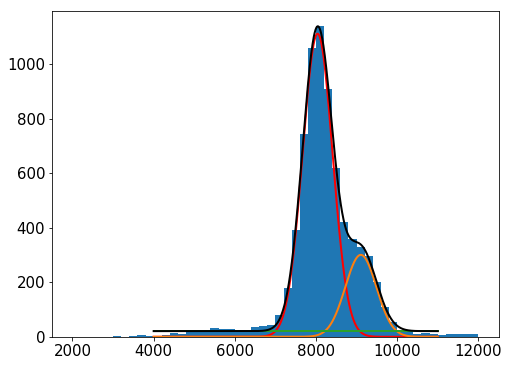

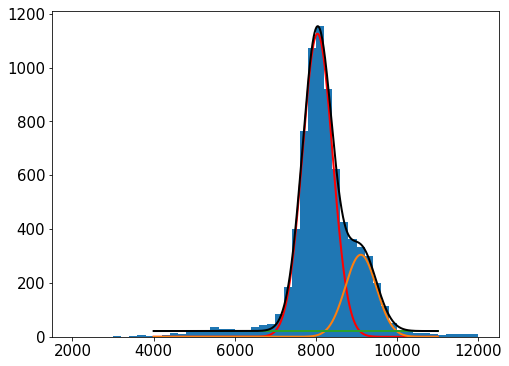

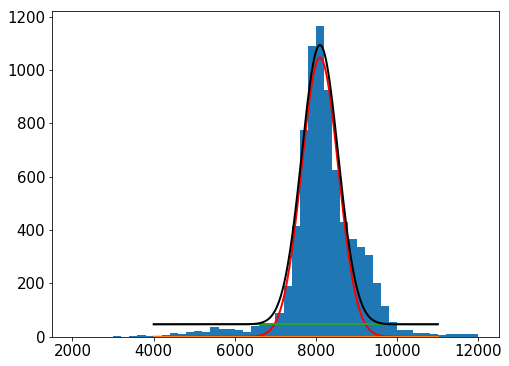

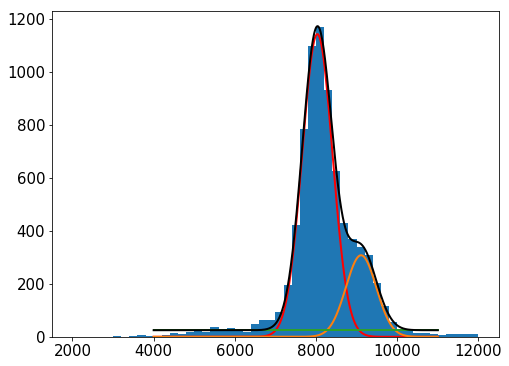

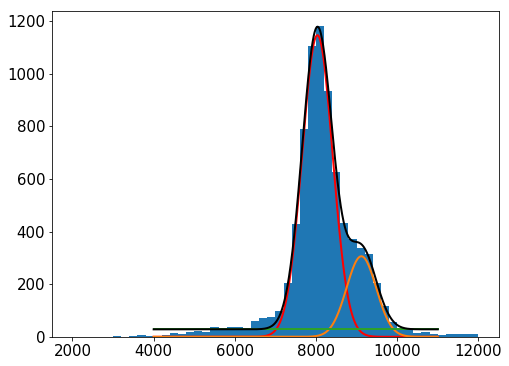

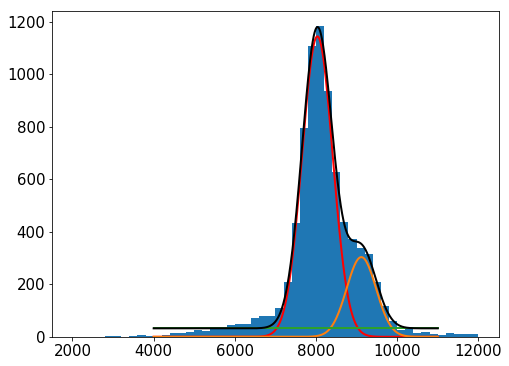

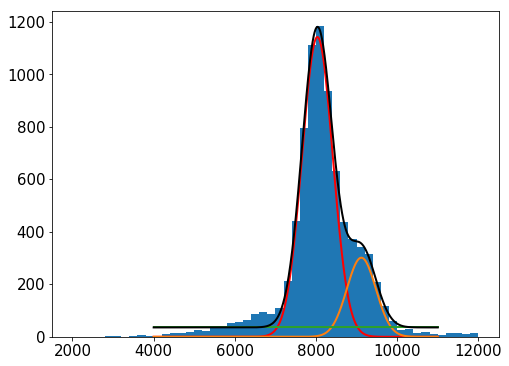

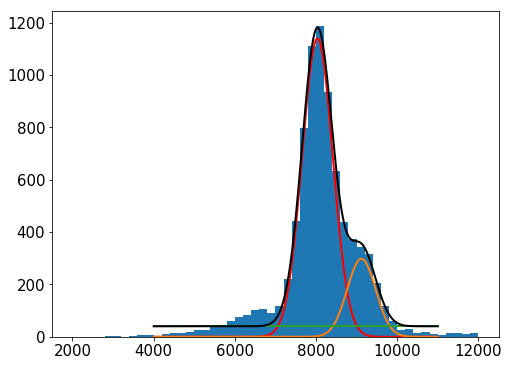

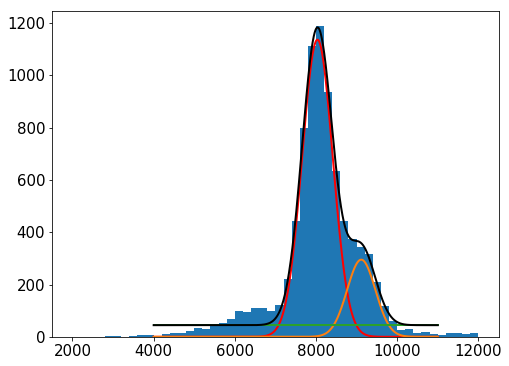

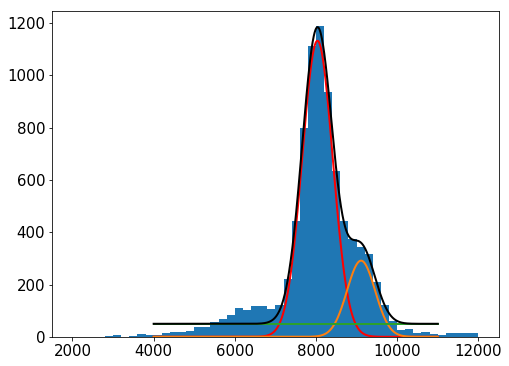

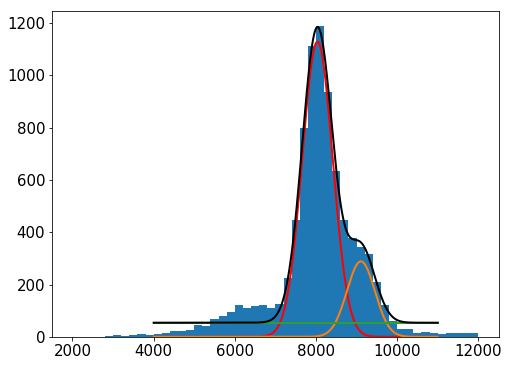

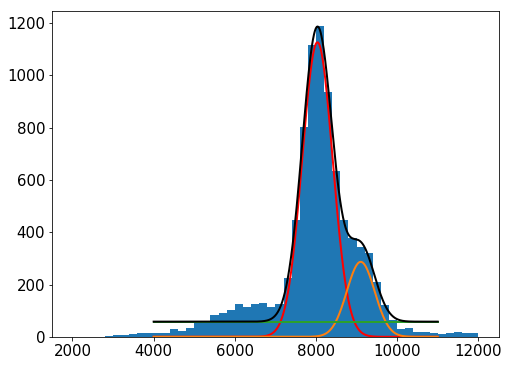

In [45]:
R_list = np.linspace(50,200,75)
res_list = []

for Rcut in R_list:

    data_             = data_sum_corr_XR
    data_             = data_[(data_.R<Rcut)&(data_.Z<150)]
    Ez_               = data_.S2e * xycorr(data_.X.values, data_.Y.values)

    entries, xbins, _ = hist(Ez_, 50, range=(2e3, 12e3))
    xbins    = get_centers(xbins)
    selbins  = fitf.in_range(xbins, 5e3, 12e3)


    f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 9230, 500, 10),
                                                    bounds= ([ 1e4, 6000, 100, 0.1e4, 8500, 0.00, 0],
                                                             [ 10e6, 8500, 700,10e5, 150000,600, 300] ))
    mean, sigma = f.values[1], f.values[2]
    res = 2.355*sigma/mean*(29.6/2458)**0.5*100
    res_list.append(res)
    
    xrange = np.linspace(4e3, 11e3,1000)

    #plt.text(min(xbins)-100, 200, text, fontsize=15);
    plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
    plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
    plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
    plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
    
    print(f.values)

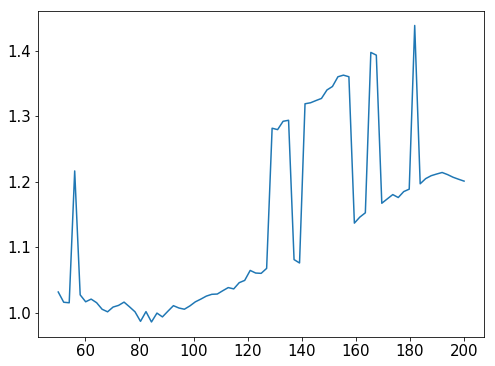

In [46]:
plt.plot(R_list,res_list)
#labels("R cut","res")
#save("res ver R cut")

[  4.41947027e+07   1.40086389e+05   5.04973188e+03   3.37952234e+01]
res 0.0848913204204 0.0387064017075


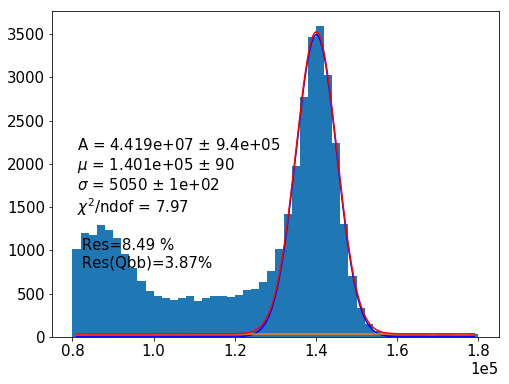

In [47]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.3e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  8.30179084e+04   7.99179879e+03   3.07439901e+02   3.04684794e+04
   8.98762308e+03   4.12538305e+02   1.01103402e+00]
res 0.0905954948793 0.0413072337705


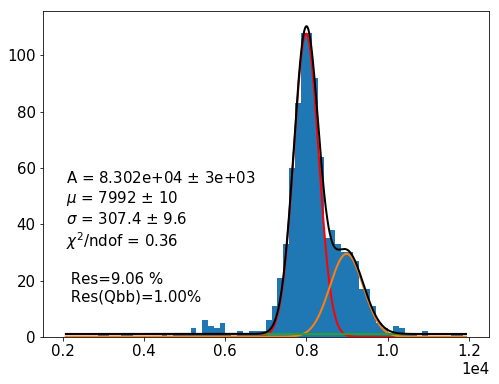

In [48]:
data_ = pd.concat([data_cut_corr["3783"]["XR"],data_cut_corr["3787"]["XR"],data_cut_corr["3789"]["XR"],data_cut_corr["3791"]["XR"],data_cut_corr["3794"]["XR"]])
data_ = data_[(data_.R<100)&(data_.Z<150)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values)


entries, xbins, _ = hist(E, 70, range=(2e3, 12e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 7.5e3, 12e3)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 1e4, 9230, 100, 10),
                                                bounds= ([ 1e4, 6000, 100, 0.1e3, 8500, 0.00, 0],
                                                         [ 10e6, 8500, 700,10e4, 10000,1000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
    
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  9.55120562e+04   8.12044666e+03   3.60792455e+02   1.83300643e+04
   9.25676434e+03   3.07831291e+02   9.48662829e-01]
res 0.104632942958 0.0131798298896


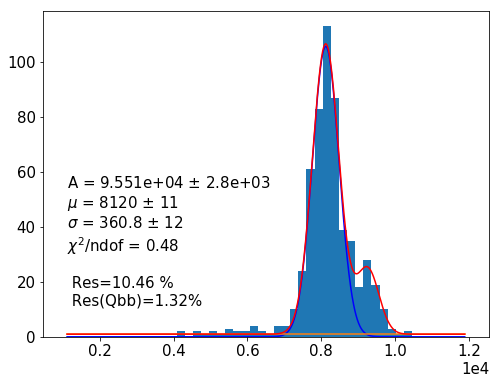

In [49]:
data_ = data_cut_corr["3890"]["XR"]
data_ = data_[(data_.R<180)&(data_.Z <150)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(1e3, 12e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.35e3, 112e3)


f        = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 9e4, 7000, 500, 9e4, 9050, 500, 10),
                                                              bounds= ([ 1e4, 6000, 100, 0.1e4, 8000, 100, 0],
                                                                      [ 10e6, 8500, 500,10e5, 100000,600, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(39/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (39/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  1.10917740e+07   1.40315943e+05   4.29165184e+03   7.37943476e+00]
[  1.15419209e+07   1.40287620e+05   4.31424465e+03   7.30257801e+00]
[  1.20490530e+07   1.40265497e+05   4.34220604e+03   7.59572567e+00]
[  1.25245240e+07   1.40263007e+05   4.36015874e+03   8.34967969e+00]
[  1.30398803e+07   1.40242078e+05   4.39026062e+03   8.06910648e+00]
[  1.35590988e+07   1.40244169e+05   4.40042645e+03   8.37584749e+00]
[  1.40809469e+07   1.40231188e+05   4.42135293e+03   8.34078064e+00]
[  1.46339277e+07   1.40220063e+05   4.43821563e+03   8.51922522e+00]
[  1.51278960e+07   1.40207902e+05   4.45149636e+03   9.26036756e+00]
[  1.56754397e+07   1.40220718e+05   4.46531438e+03   9.54107832e+00]
[  1.61538191e+07   1.40258237e+05   4.44350252e+03   1.00580760e+01]
[  1.66815399e+07   1.40270087e+05   4.43920965e+03   1.08448280e+01]
[  1.71485643e+07   1.40296841e+05   4.43346063e+03   1.13545057e+01]
[  1.76190113e+07   1.40311755e+05   4.42823643e+03   1.22599678e+01]
[  1.80756303e+07   

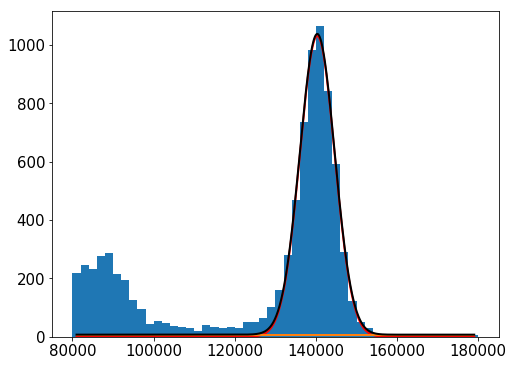

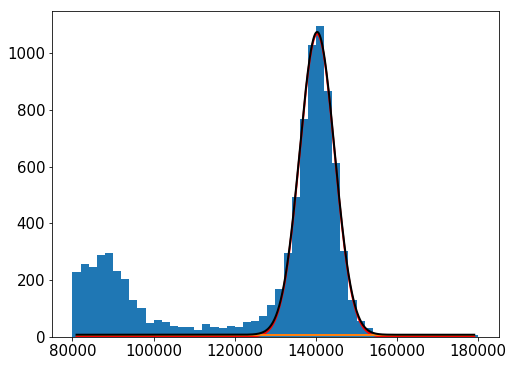

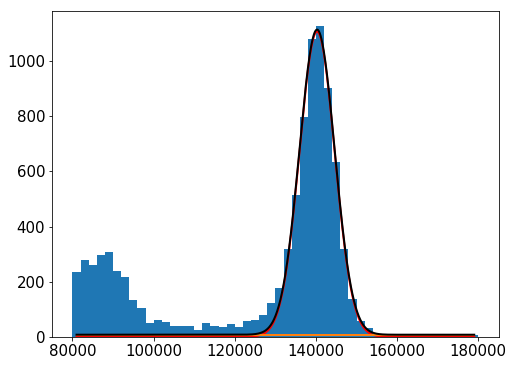

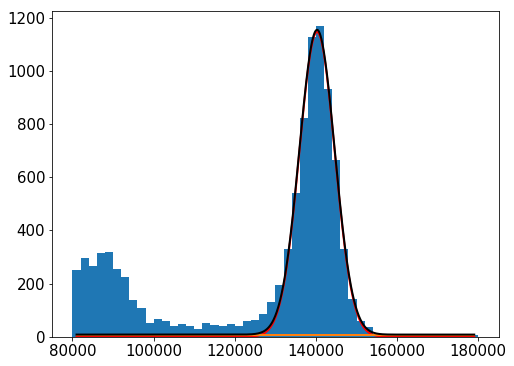

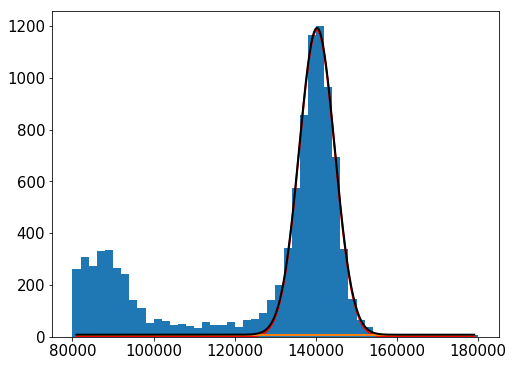

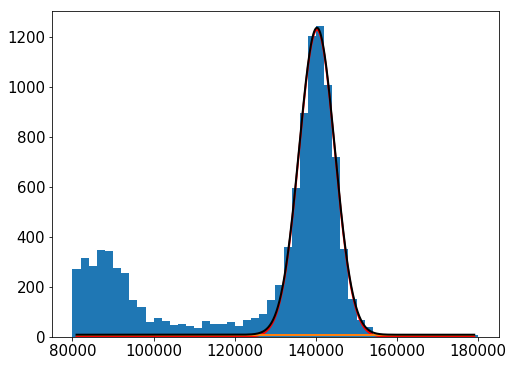

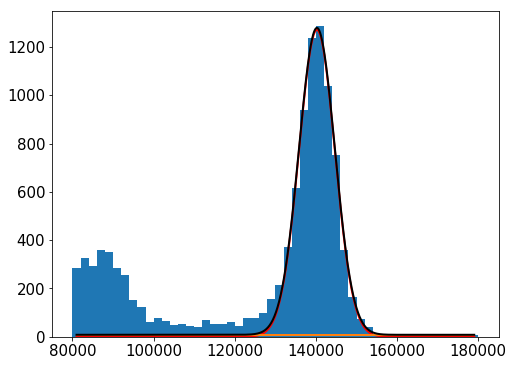

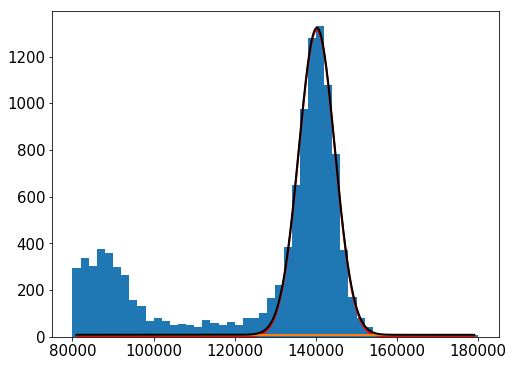

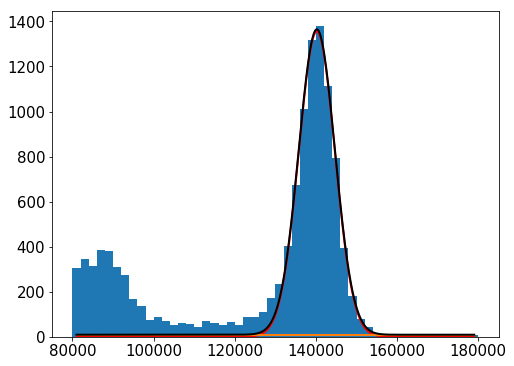

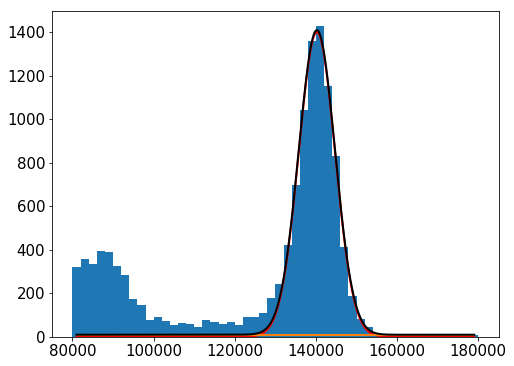

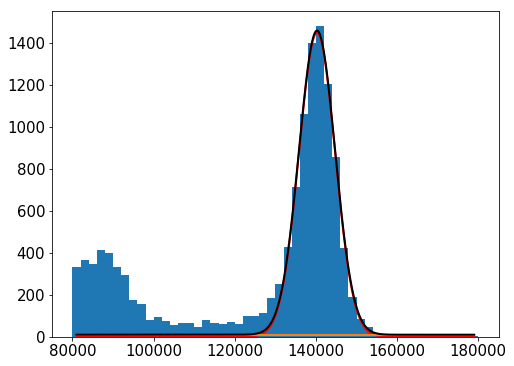

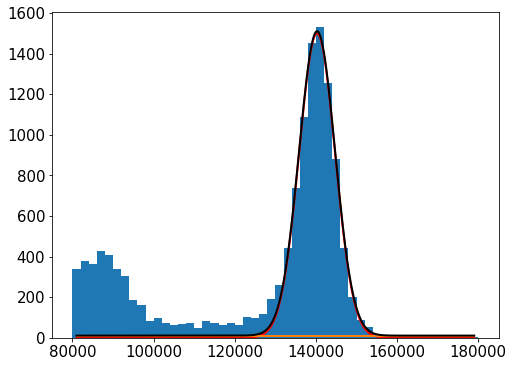

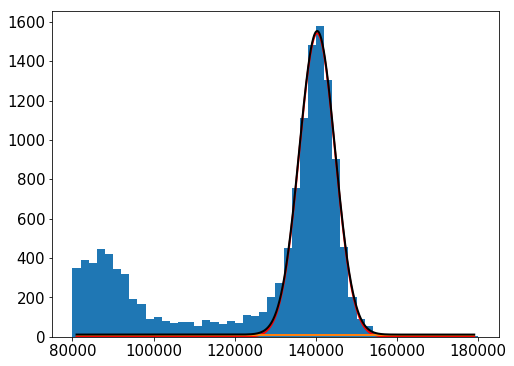

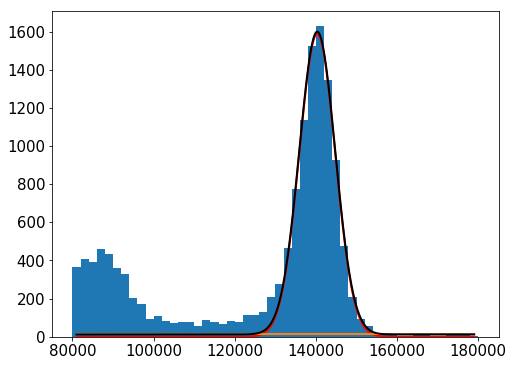

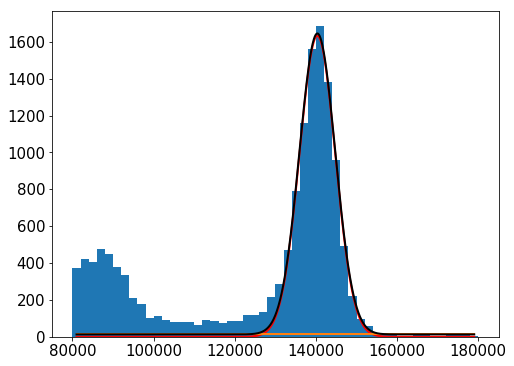

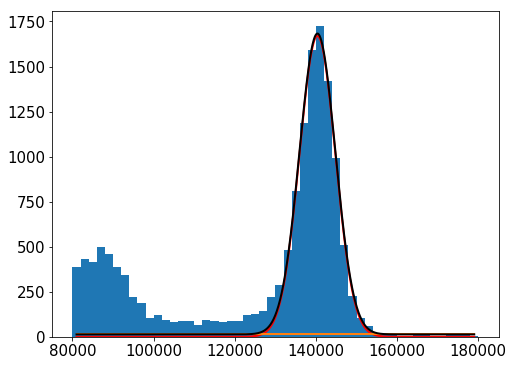

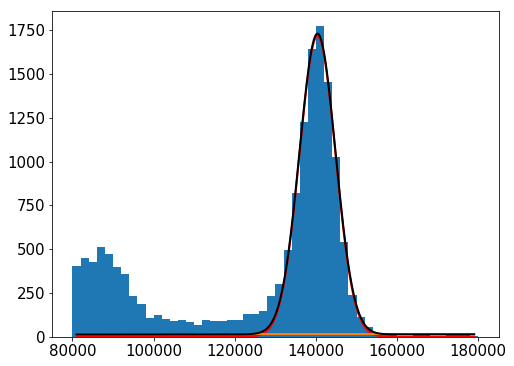

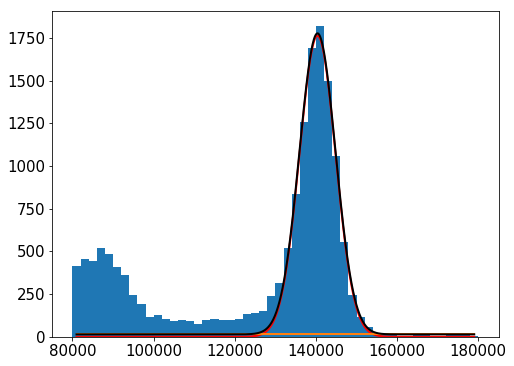

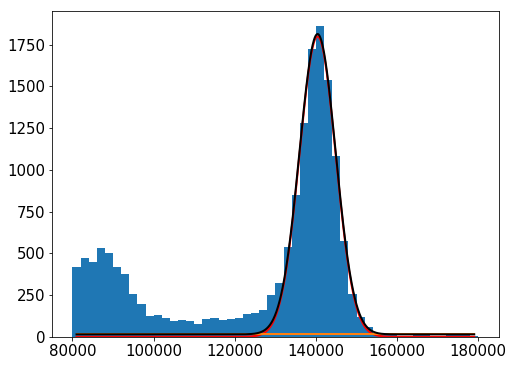

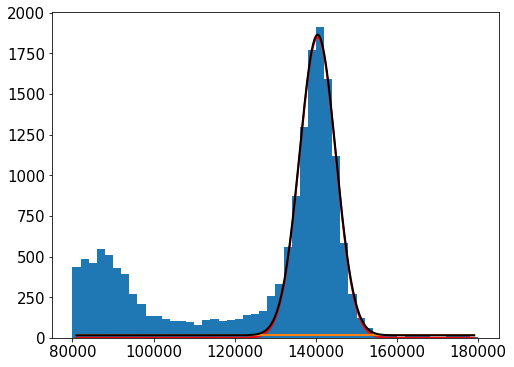

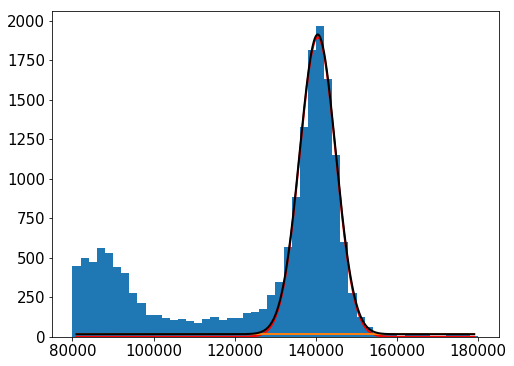

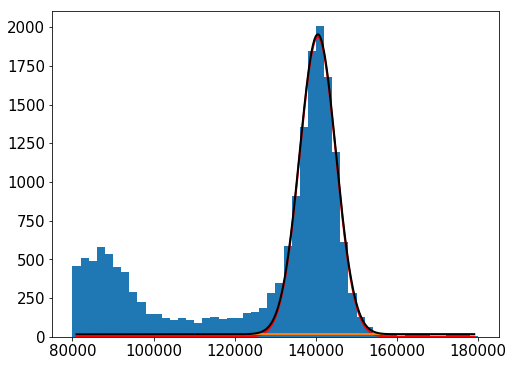

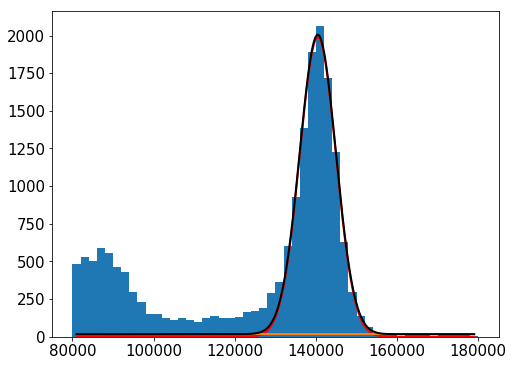

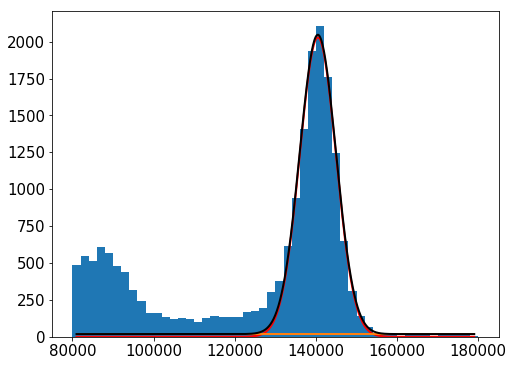

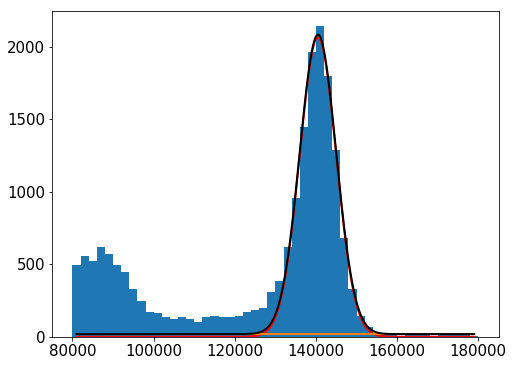

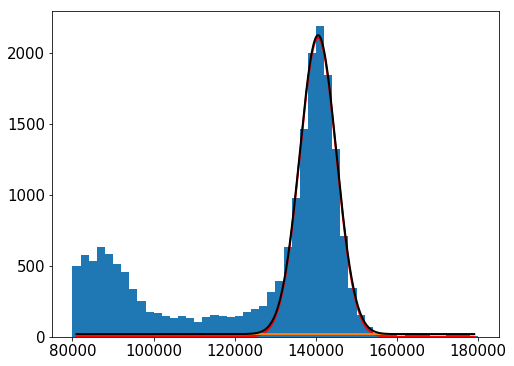

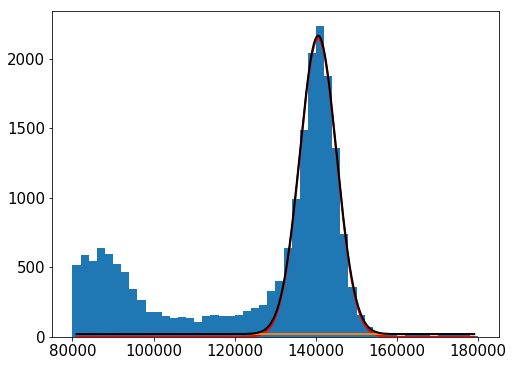

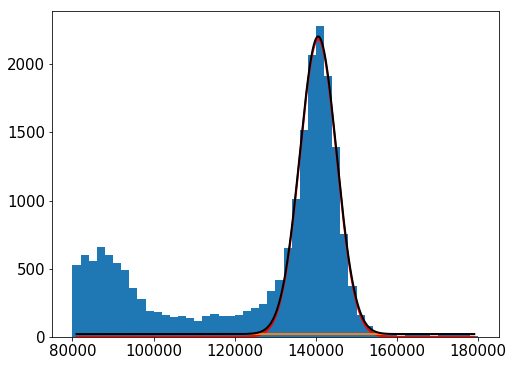

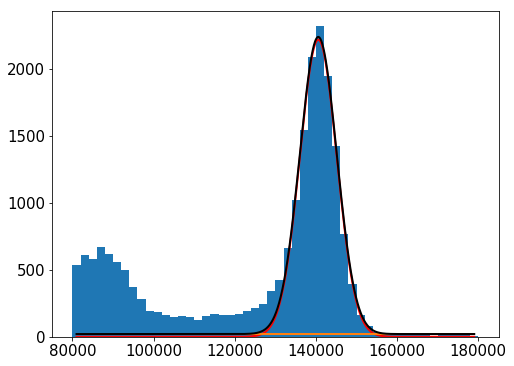

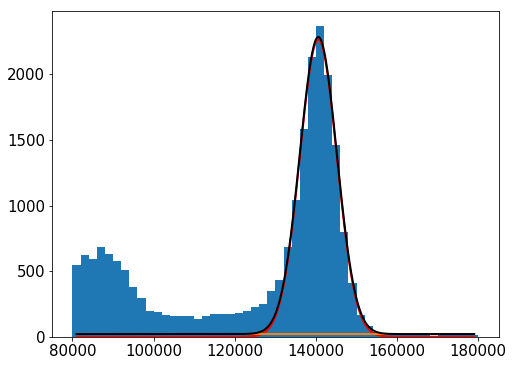

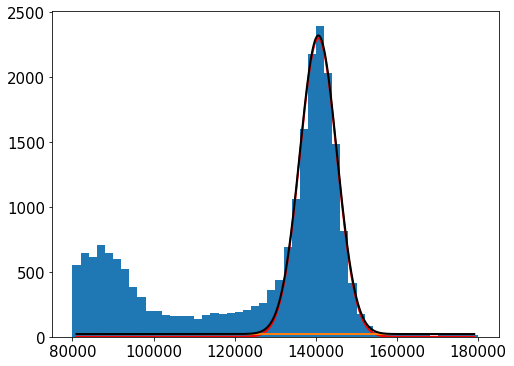

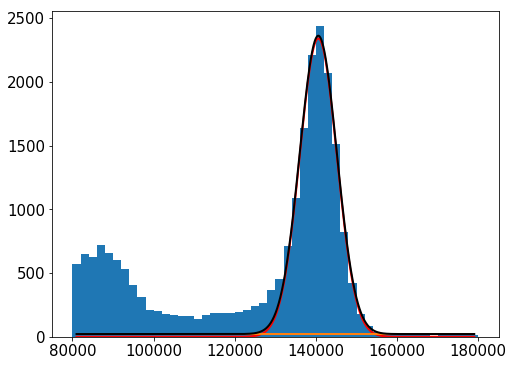

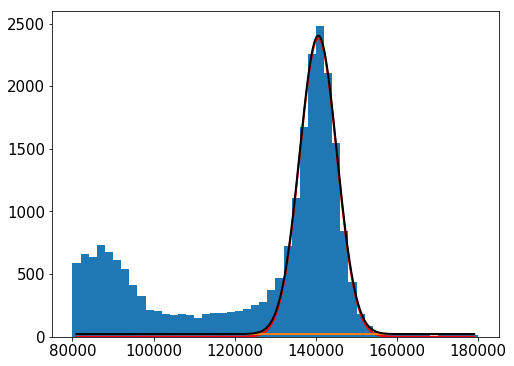

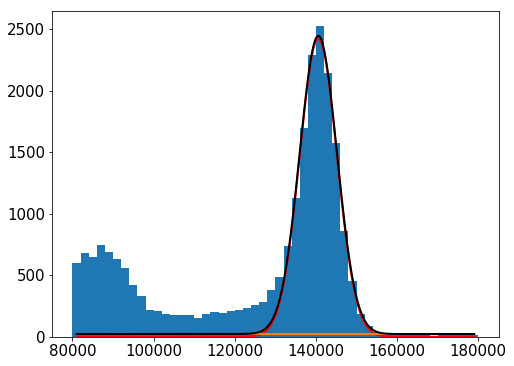

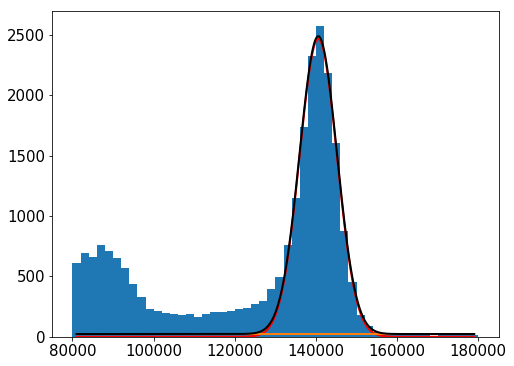

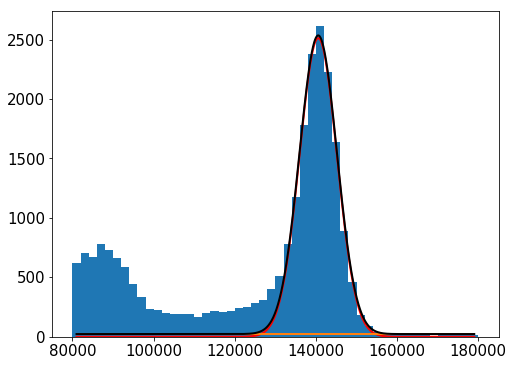

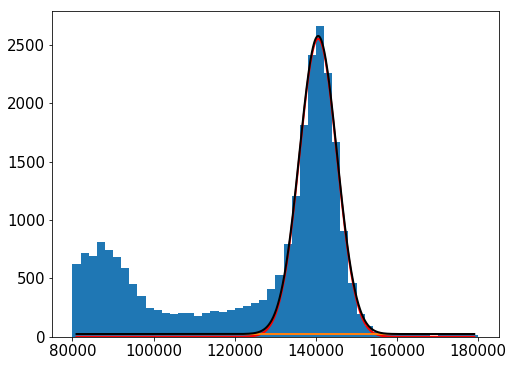

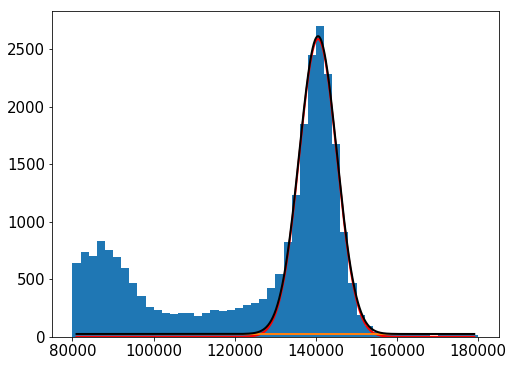

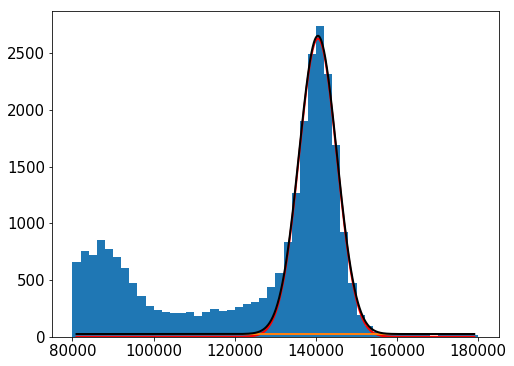

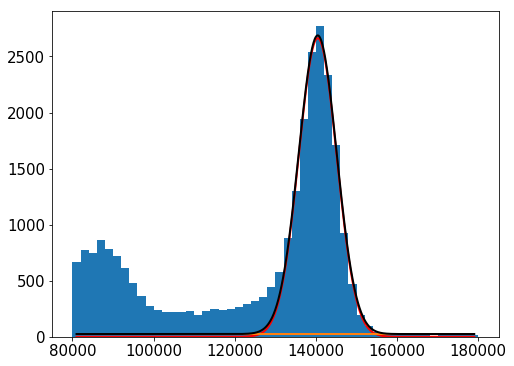

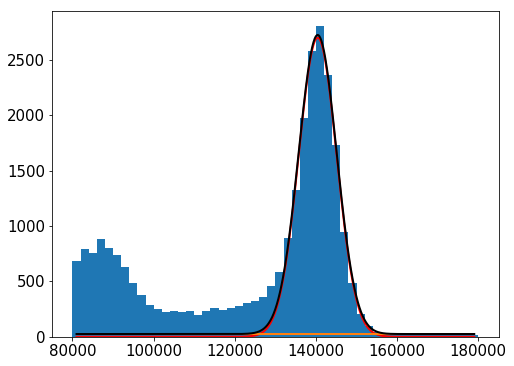

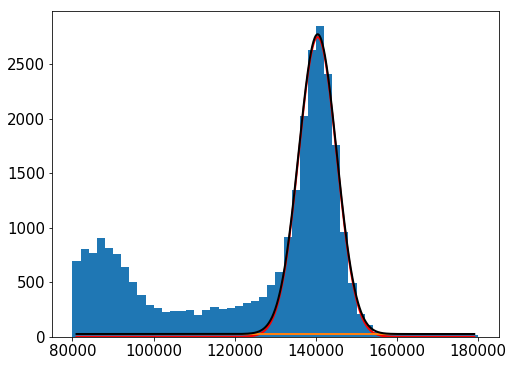

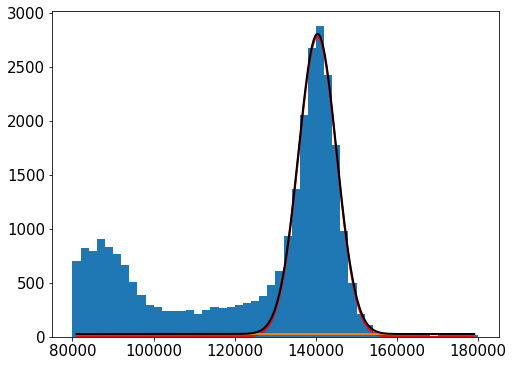

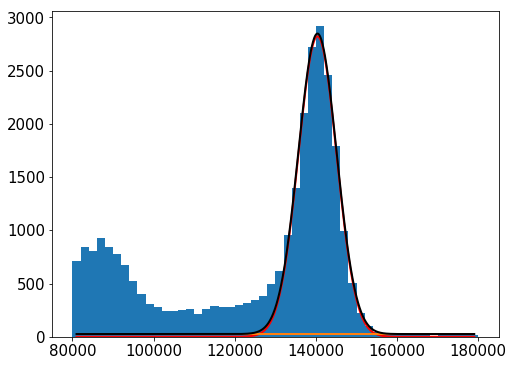

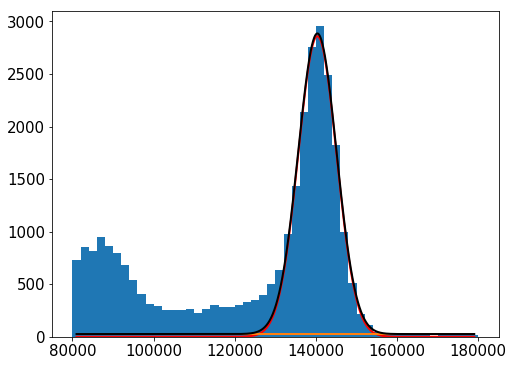

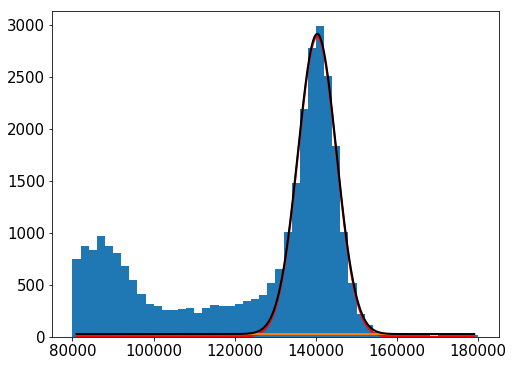

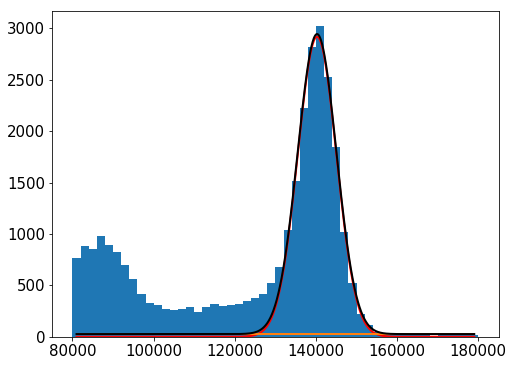

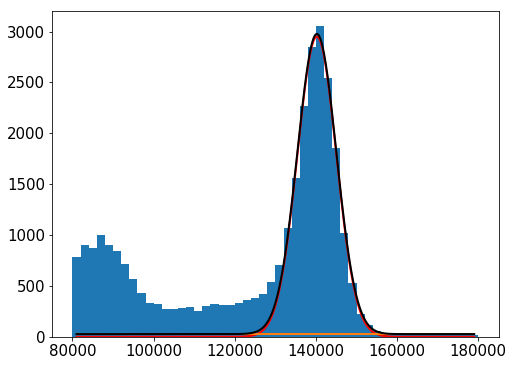

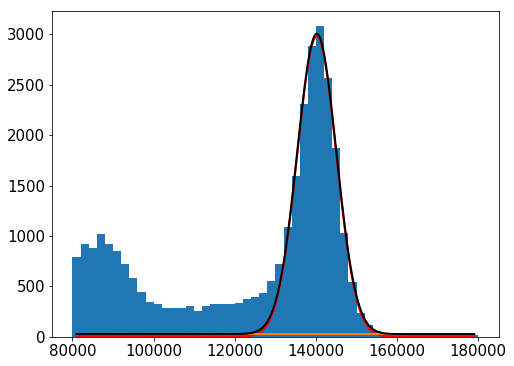

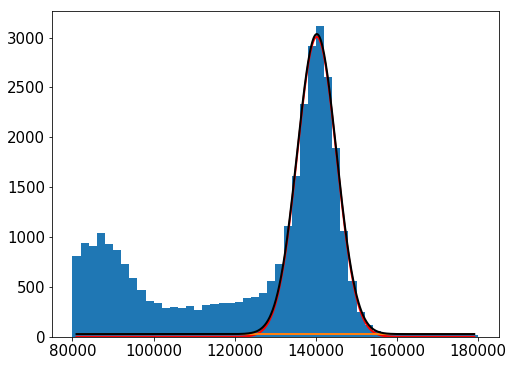

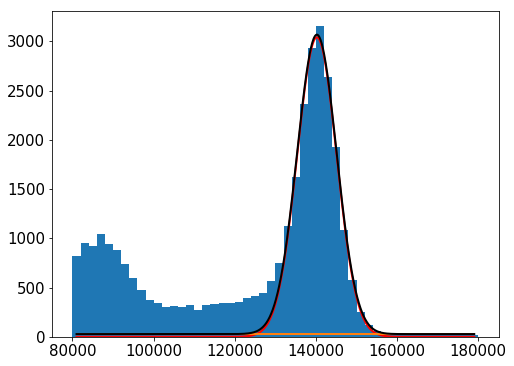

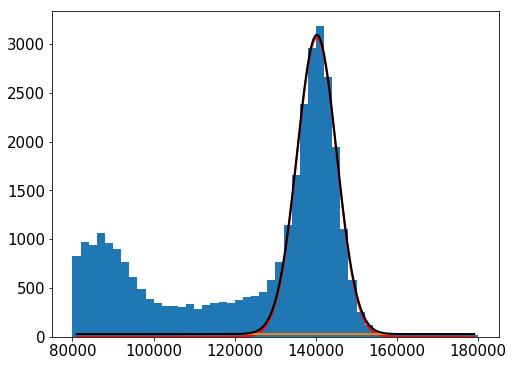

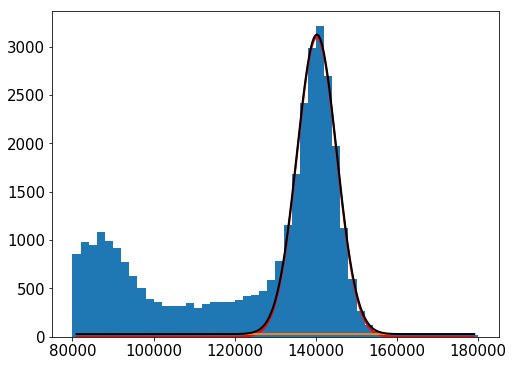

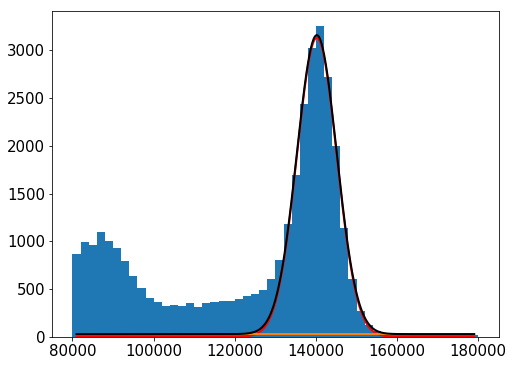

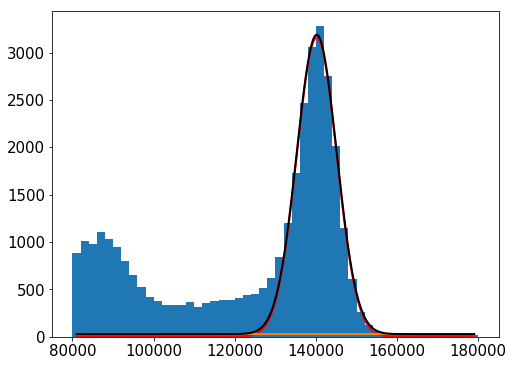

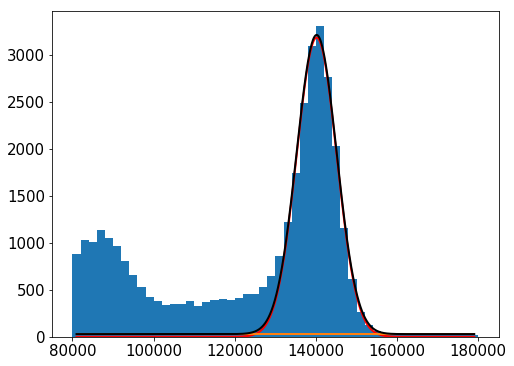

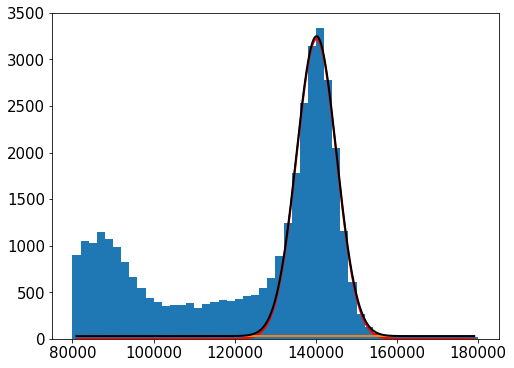

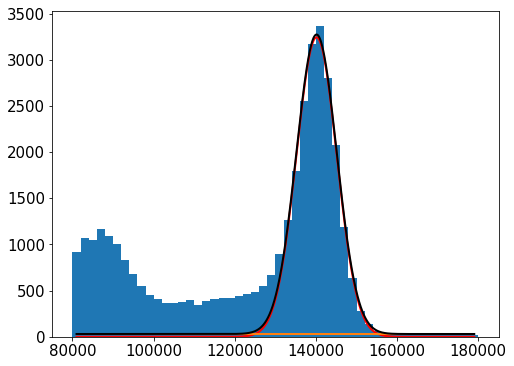

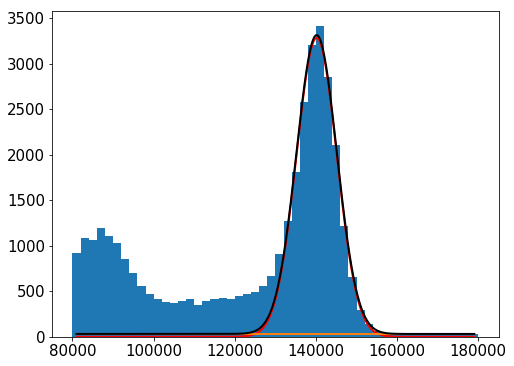

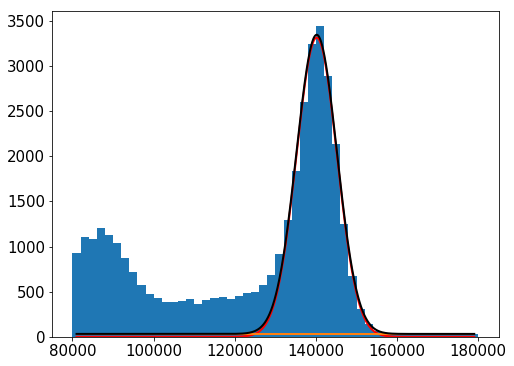

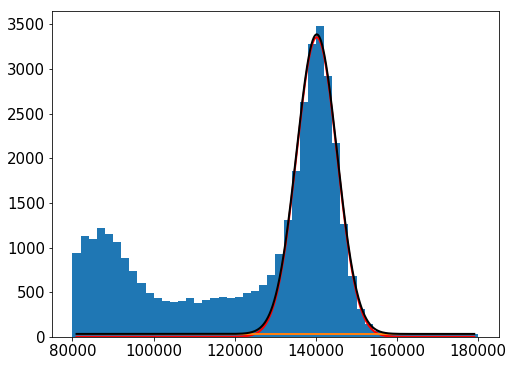

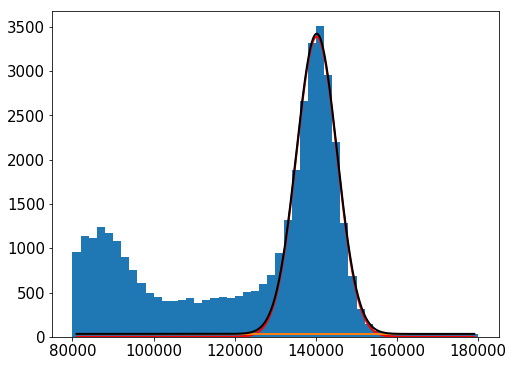

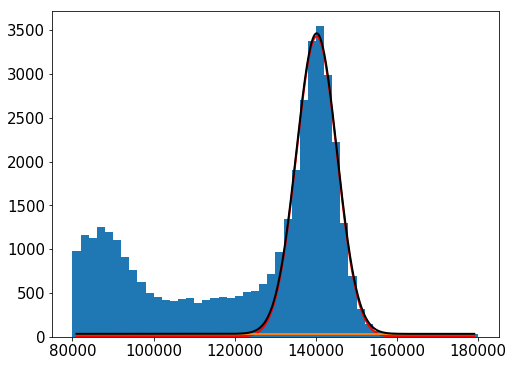

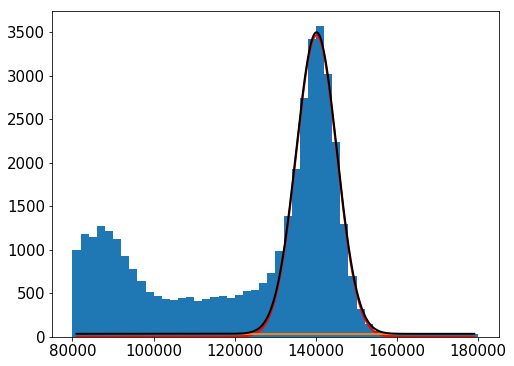

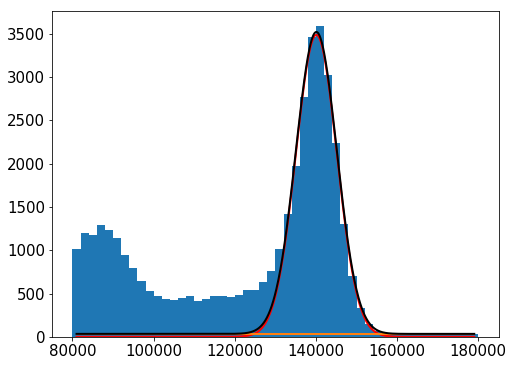

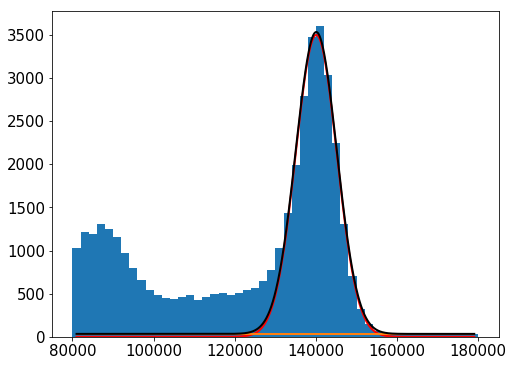

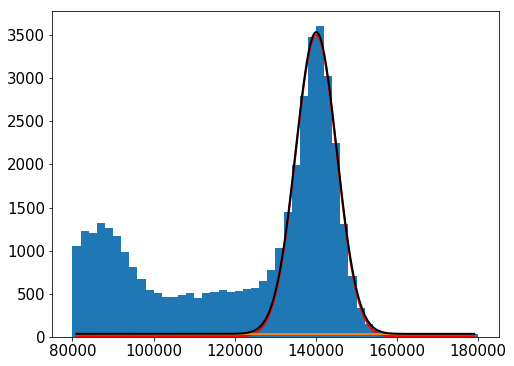

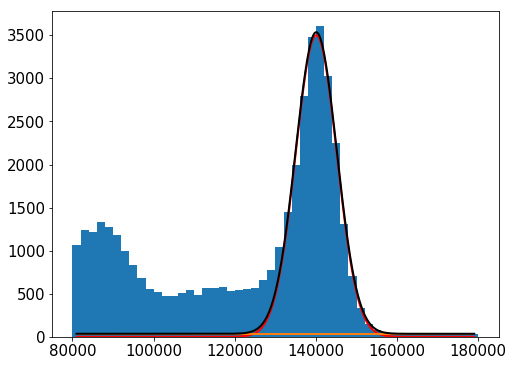

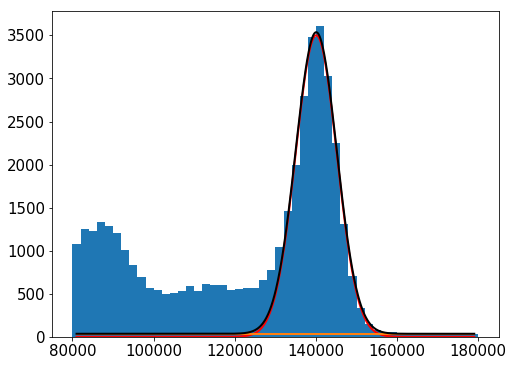

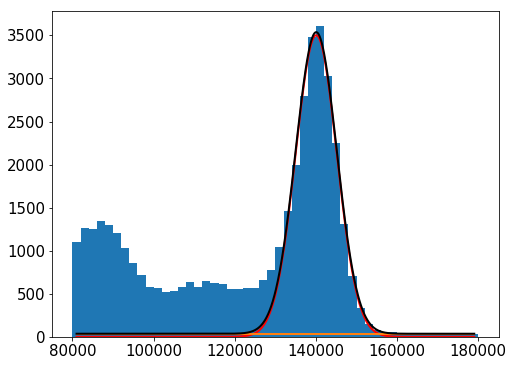

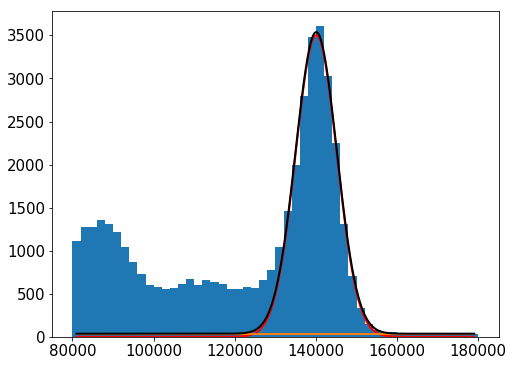

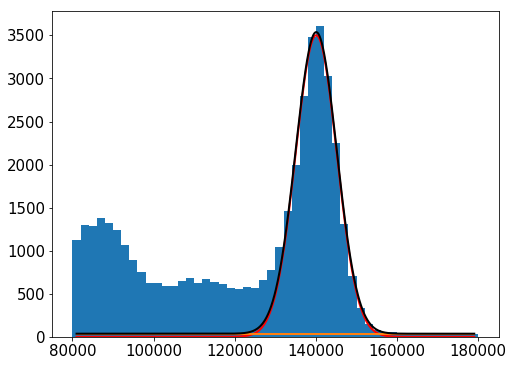

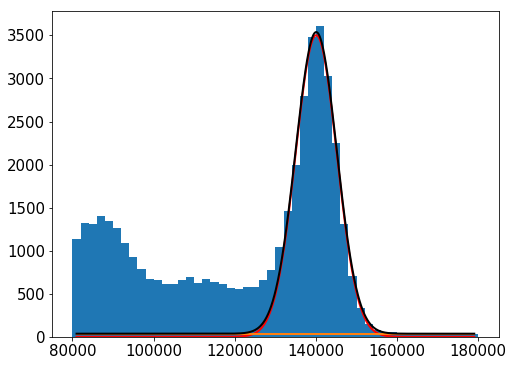

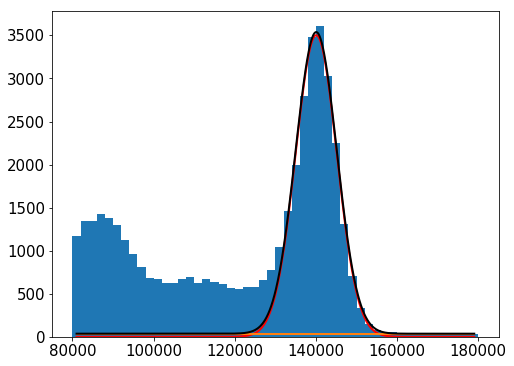

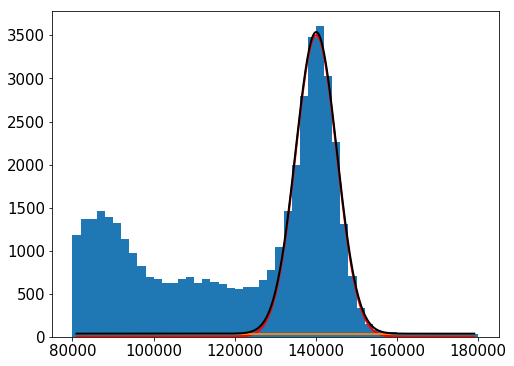

In [50]:
R_list = np.linspace(50,200,75)
res_list = []

for Rcut in R_list:

    data_ = data_sum_corr[(data_sum_corr.R<Rcut)&(data_sum_corr.nS2 ==1)]
    E = data_.S2e * xycorr(data_.X.values, data_.Y.values)

    entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
    xbins    = get_centers(xbins)
    selbins  = fitf.in_range(xbins, 1.3e5, 1.8e5)


    f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                     bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))


    mean, sigma = f.values[1], f.values[2]
    res = 2.355*sigma/mean*(511/2458)**0.5*100
    res_list.append(res)
    
    xrange = np.linspace(xbins[0], xbins[-1],1000)

    #plt.text(min(xbins)-100, 200, text, fontsize=15);
    plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
    plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
    plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
    
    print(f.values)

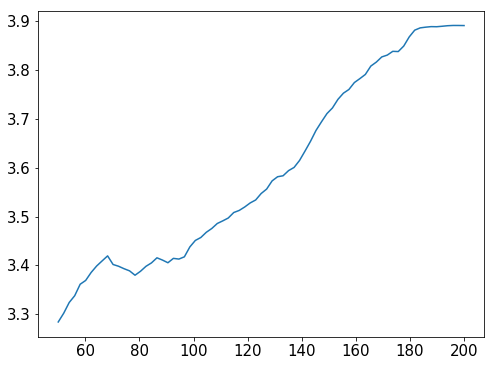

In [51]:
plt.plot(R_list,res_list)
#labels("R cut","res")
#save("res ver R cut")

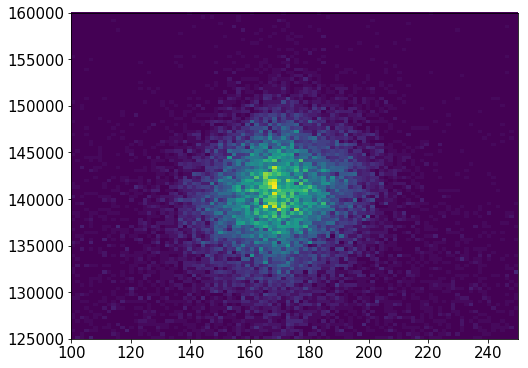

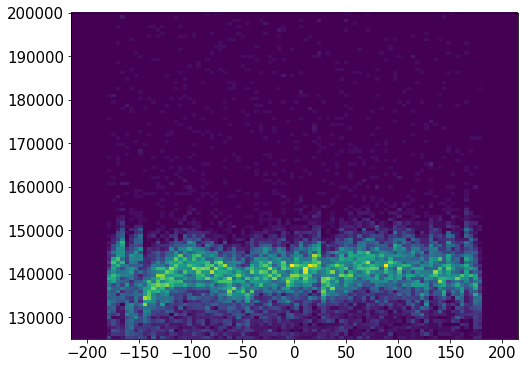

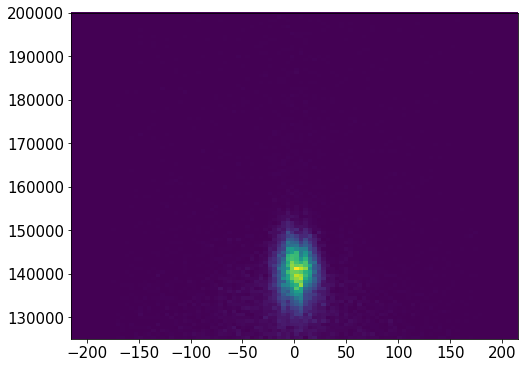

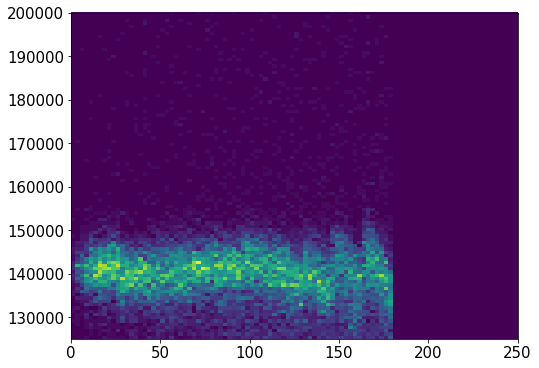

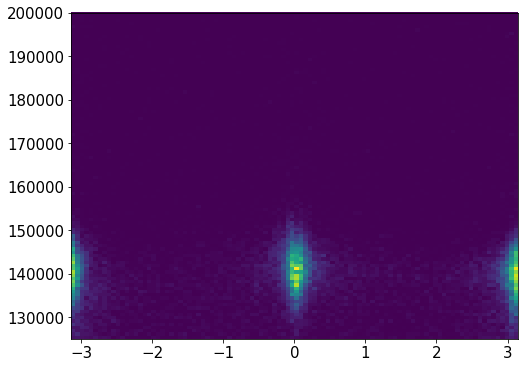

In [52]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values)

hist2d(data_.Z,E,[100,100],[[100,250],[1.25e5, 1.6e5]]);
hist2d(data_.X,E,[100,100],[[-215,215],[1.25e5, 2e5]]);
hist2d(data_.Y,E,[100,100],[[-215,215],[1.25e5, 2e5]]);
hist2d(data_.R,E,[100,100],[[0,250],[1.25e5, 2e5]]);
hist2d(data_.Phi,E,[100,100],[[-pi,pi],[1.25e5, 2e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

111964.249191


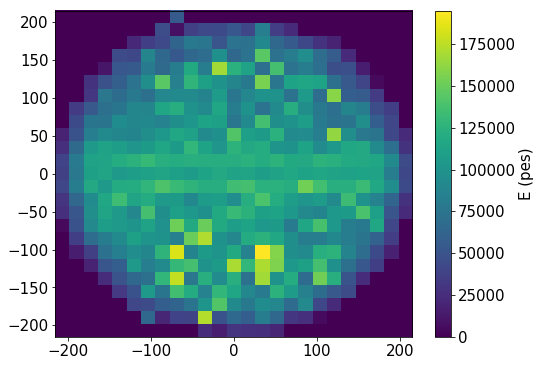

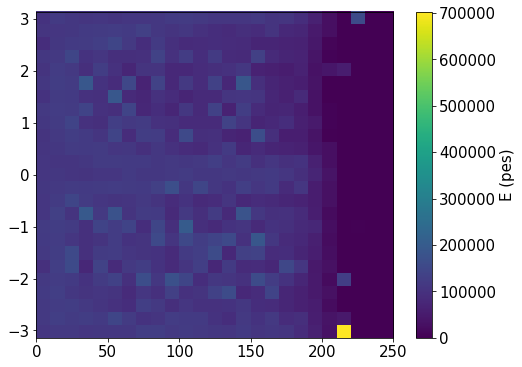

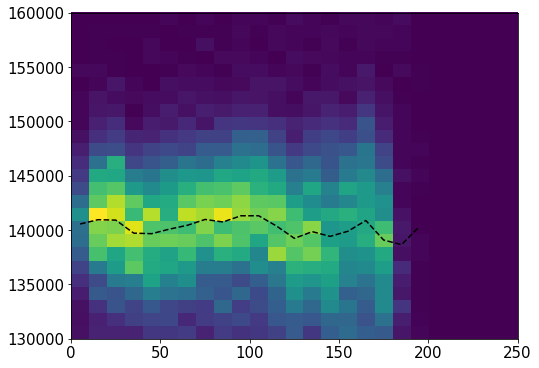

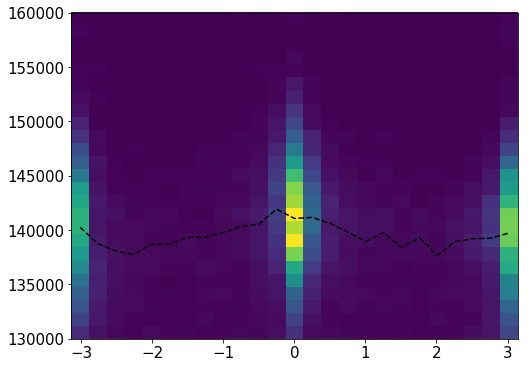

In [54]:
xrange =   -215, 215
yrange =   -215, 215
rrange =      0, 250
prange =   - pi,  pi
Erange =  1.3e5, 1.6e5
nbin = 25

#data = filt_XR[filt_XR.Z<150][:]
data = data_sum_corr
data = data[(data.R<250)&(data_sum_corr.nS2 ==1)][:]
Ez   = data.S2e * xycorr(data.X.values, data.Y.values)


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
#labels("x (mm)", "y (mm)")
#save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
#labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
#labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
#labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

'''
np.savetxt('xycorr_xs_3614.dat',np.array(pf[0]))
np.savetxt('xycorr_ys_3614.dat',np.array(pf[1]))
np.savetxt('xycorr_es_3614.dat',np.array(pf[2]))
'''



def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr_PP = get_xycorr(*pf[:-1])

TypeError: 'silent_list' object is not callable

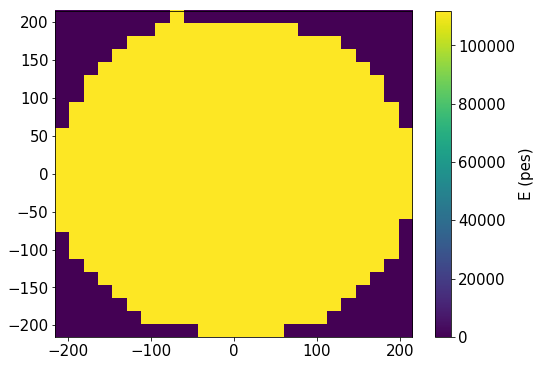

In [55]:
xrange =   -215, 215
yrange =   -215, 215
rrange =      0, 250
prange =   - pi,  pi
Erange =  1.3e5, 1.6e5
nbin = 25

#data = filt_XR[filt_XR.Z<150][:]
data = data_sum_corr
data = data[(data.R<250)&(data_sum_corr.nS2 ==1)][:]
Ez   = data.S2e * xycorr(data.X.values, data.Y.values)* xycorr_PP(data.X.values, data.Y.values)


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
#save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")



In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<100)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) * xycorr_PP(data_.X.values, data_.Y.values) 

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.3e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) *xycorr_PP(data_.X.values, data_.Y.values)

hist2d(data_.Z,E,[100,100],[[100,250],[1.25e5, 1.6e5]]);
hist2d(data_.X,E,[100,100],[[-215,215],[1.25e5, 2e5]]);
hist2d(data_.Y,E,[100,100],[[-215,215],[1.25e5, 2e5]]);
hist2d(data_.R,E,[100,100],[[0,250],[1.25e5, 2e5]]);
hist2d(data_.Phi,E,[100,100],[[-pi,pi],[1.25e5, 2e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) 
hist2d(data_.X,E,[100,100],[[-215,215],[1.25e5, 1.6e5]]);
x, y, _ = fitf.profileX(data_.X,E, 100, xrange=[-180, 180], yrange=[1.25e5,1.6e5])
plt.plot(x, y, profOpt, linewidth=3)

def get_xcorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
xcorr_PP = get_xcorr(x, y)

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xcorr_PP(data_.X.values) * xycorr(data_.X.values, data_.Y.values) * xcorr_PP(data_.X.values)
hist2d(data_.Y,E,[100,100],[[-50,50],[1.25e5, 1.6e5]]);
x, y, _ = fitf.profileX(data_.Y,E, 100, xrange=[-25, 25], yrange=[1.25e5,1.6e5])
plt.plot(x, y, profOpt, linewidth=3)

def get_xcorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
ycorr_PP = get_xcorr(x, y)
ycorr_PP(np.array([0]))

In [ ]:
data_ = data_sum_corr
data_ = data_[(data_.R<180)&(data_.nS2 ==1)&(data_.Y>-20)&(data_.Y<20)&(data_.X>-140)&(data_.X<0)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) * xcorr_PP(data_.X.values) * ycorr_PP(data_.Y.values)

hist2d(data_.X,E,[50,50],[[-215,215],[1.25e5, 2e5]]);
x, y, _ = fitf.profileX(data_.X,E, 50, xrange=[-180, 180], yrange=[1.3e5,1.55e5])
plt.plot(x, y, profOpt, linewidth=3)

hist2d(data_.Y,E,[100,100],[[-50,50],[1.25e5, 2e5]]);
x, y, _ = fitf.profileX(data_.Y,E, 100, xrange=[-180, 180], yrange=[1.3e5,1.55e5])
plt.plot(x, y, profOpt, linewidth=3)

hist2d(data_.Z,E,[50,50],[[130,210],[1.25e5, 2e5]]);
x, y, _ = fitf.profileX(data_.Z,E, 50, xrange=[130, 210], yrange=[1.3e5,1.55e5])
plt.plot(x, y, profOpt, linewidth=3)

time  = data_.time
time -= np.min(time)
hist2d(time,E,[50,50],[[0,0.75e5],[1.25e5, 2e5]]);
x, y, _ = fitf.profileX(time,E, 50, xrange=[0,0.75e5], yrange=[1.3e5,1.55e5])
plt.plot(x, y, profOpt, linewidth=3)


In [ ]:
data_ = data_sum_corr
data_= data_[(data_.R<100)&(data_.nS2 ==1)&(data_.Y>-10)&(data_.Y<10)&(data_.X>-140)&(data_.X<0)&(data_.Z>155)&(data_.Z<170)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) * xcorr_PP(data_.X.values)* ycorr_PP(data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.4e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<100)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) * xycorr_PP(data_.X.values,data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.3e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) *xcorr_PP(data_.X.values)

hist2d(data_.Z,E,[100,100],[[100,250],[1.25e5, 1.6e5]]);
hist2d(data_.X,E,[100,100],[[-215,215],[1.25e5, 2e5]]);
hist2d(data_.Y,E,[100,100],[[-50,50],[1.25e5, 2e5]]);
hist2d(data_.R,E,[100,100],[[0,250],[1.25e5, 2e5]]);
hist2d(data_.Phi,E,[100,100],[[-pi,pi],[1.25e5, 2e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [ ]:
data_ = data_sum_corr[(data_sum_corr.R<100)&(data_sum_corr.nS2 ==1)]
E = data_.S2e * xycorr(data_.X.values, data_.Y.values) * xcorr_PP(data_.X.values) * ycorr_PP(data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.3e5, 1.8e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.3e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

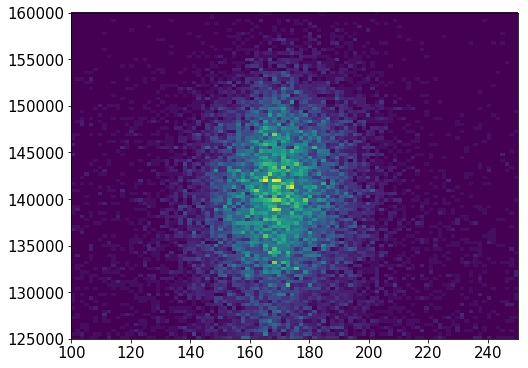

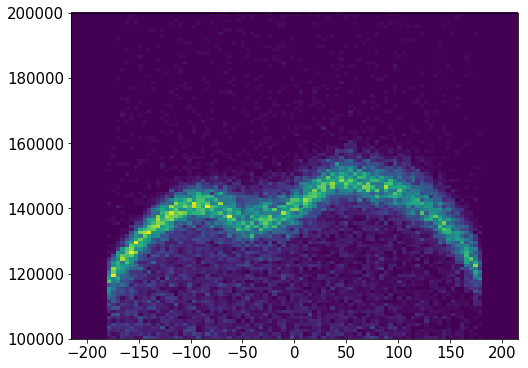

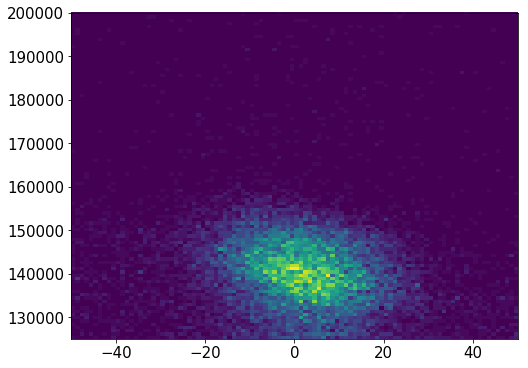

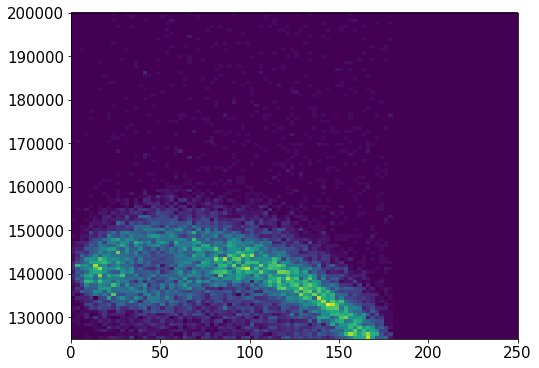

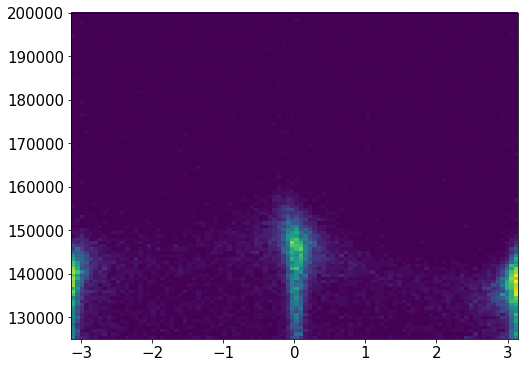

In [56]:
data_ = data_sum_corr[(data_sum_corr.R<180)&(data_sum_corr.nS2 ==1)]
E = data_.S2e 
hist2d(data_.Z,E,[100,100],[[100,250],[1.25e5, 1.6e5]]);
hist2d(data_.X,E,[100,100],[[-215,215],[1.0e5, 2e5]]);
hist2d(data_.Y,E,[100,100],[[-50,50],[1.25e5, 2e5]]);
hist2d(data_.R,E,[100,100],[[0,250],[1.25e5, 2e5]]);
hist2d(data_.Phi,E,[100,100],[[-pi,pi],[1.25e5, 2e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))